In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import re
import itertools
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from prophet import Prophet
from sklearn.preprocessing import LabelEncoder
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    DynamicOptimizedTheta,
    HoltWinters,
    ADIDA,
    AutoETS
)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import ipywidgets as widgets
from IPython.display import display
from jinja2 import Template
from statsforecast.models import HoltWinters
from tqdm import tqdm


In [2]:
#Loading the dataset
Crime_Statistics = pd.read_csv("./35100177.csv", dtype={'DGUID': str, 'TERMINATED': str}, low_memory=False)

In [3]:
#Displaying first five rows
Crime_Statistics.head(5)

REF_DATE     GEO           DGUID                 Violations  \
0      1998  Canada  2021A000011124  Total, all violations [0]   
1      1998  Canada  2021A000011124  Total, all violations [0]   
2      1998  Canada  2021A000011124  Total, all violations [0]   
3      1998  Canada  2021A000011124  Total, all violations [0]   
4      1998  Canada  2021A000011124  Total, all violations [0]   

                                          Statistics      UOM  UOM_ID  \
0                                   Actual incidents   Number     223   
1                        Rate per 100,000 population     Rate     257   
2                          Percentage change in rate  Percent     239   
3  Percentage contribution to the Crime Severity ...  Percent     239   
4                                Unfounded incidents   Number     223   

  SCALAR_FACTOR  SCALAR_ID       VECTOR COORDINATE       VALUE STATUS  SYMBOL  \
0         units          0    v44348247      1.1.1  2688540.00    NaN     NaN   
1         units          0    v44396346      1.1.2     8915.12    NaN     NaN   
2         units          0    v44391402      1.1.3         NaN     ..     NaN   
3         units          0  v1545644596     1.1.17      100.00    NaN     NaN   
4         units          0  v1000149311     1.1.15         NaN     ..     NaN   

  TERMINATED  DECIMALS  
0        NaN         0  
1        NaN         2  
2        NaN         2  
3        NaN         2  
4        NaN         0

## 2. Understand the Dataset

In [4]:
#Checking the shape of the dataset
Crime_Statistics.shape

(7244910, 16)

The dataset includes 7244910 rows and 16 columns.

In [5]:
#Checking the columns of the dataset
Crime_Statistics.columns

Index(['REF_DATE', 'GEO', 'DGUID', 'Violations', 'Statistics', 'UOM', 'UOM_ID',
       'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS',
       'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='object')

The names of the 16 columns are: 'REF_DATE', 'GEO', 'DGUID', 'Violations', 'Statistics', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS', 'SYMBOL', 'TERMINATED', and 'DECIMALS'.

In [6]:
#Getting more information of the dataset
Crime_Statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7244910 entries, 0 to 7244909
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   REF_DATE       int64  
 1   GEO            object 
 2   DGUID          object 
 3   Violations     object 
 4   Statistics     object 
 5   UOM            object 
 6   UOM_ID         int64  
 7   SCALAR_FACTOR  object 
 8   SCALAR_ID      int64  
 9   VECTOR         object 
 10  COORDINATE     object 
 11  VALUE          float64
 12  STATUS         object 
 13  SYMBOL         float64
 14  TERMINATED     object 
 15  DECIMALS       int64  
dtypes: float64(2), int64(4), object(10)
memory usage: 884.4+ MB


The above data represents the data type of each columns.

## 3. Data Filtering

As per the Metadata "Youth population data are not available prior to 2004, therefore the rates shown are incorrect and should not be used", so the best approach would be to remove the dataset till the year 2004 for reliable and accurate analysis, ensuring that all insights and conclusions drawn are based on valid and dependable data.

The dataset is now focused on reliable data from 2005 onwards.

In [7]:
#Filtering data for years 2005 and beyond
Crime_Statistics = Crime_Statistics[Crime_Statistics['REF_DATE'] >= 2005]

In [8]:
#Checking the shape of the dataset after filtering data for years
Crime_Statistics.shape

(5369589, 16)

In [9]:
#Displaying first five rows
Crime_Statistics.head(5)

REF_DATE     GEO           DGUID                 Violations  \
1875321      2005  Canada  2021A000011124  Total, all violations [0]   
1875322      2005  Canada  2021A000011124  Total, all violations [0]   
1875323      2005  Canada  2021A000011124  Total, all violations [0]   
1875324      2005  Canada  2021A000011124  Total, all violations [0]   
1875325      2005  Canada  2021A000011124  Total, all violations [0]   

                                                Statistics      UOM  UOM_ID  \
1875321                                   Actual incidents   Number     223   
1875322                        Rate per 100,000 population     Rate     257   
1875323                          Percentage change in rate  Percent     239   
1875324  Percentage contribution to the Crime Severity ...  Percent     239   
1875325                                Unfounded incidents   Number     223   

        SCALAR_FACTOR  SCALAR_ID       VECTOR COORDINATE       VALUE STATUS  \
1875321         units          0    v44348247      1.1.1  2608741.00    NaN   
1875322         units          0    v44396346      1.1.2     8090.32    NaN   
1875323         units          0    v44391402      1.1.3       -3.59    NaN   
1875324         units          0  v1545644596     1.1.17      100.00    NaN   
1875325         units          0  v1000149311     1.1.15         NaN     ..   

         SYMBOL TERMINATED  DECIMALS  
1875321     NaN        NaN         0  
1875322     NaN        NaN         2  
1875323     NaN        NaN         2  
1875324     NaN        NaN         2  
1875325     NaN        NaN         0

## 4. Examine the unique values of each columns in the dataset and perform data cleaning if required

### Column #1: REF_DATE

In [10]:
#Checking unique values for "REF_DATE" column
Crime_Statistics['REF_DATE'].unique()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

The "REF_DATE" column in the dataset represents the year in which the crime was committed. The dataset includes the information about the crime committed in the years 2005 to 2023.

In [11]:
#Renaming the column "REF_DATE" to "Year"
Crime_Statistics.rename(columns={'REF_DATE': 'Year'}, inplace=True)

### Column #2: GEO

In [12]:
#Checking unique values for "GEO" column
Crime_Statistics['GEO'].unique()

array(['Canada', 'Newfoundland and Labrador [10]',
       "St. John's, Newfoundland and Labrador [10001]",
       'Prince Edward Island [11]', 'Nova Scotia [12]',
       'Halifax, Nova Scotia [12205]', 'New Brunswick [13]',
       'Moncton, New Brunswick [13305]',
       'Saint John, New Brunswick [13310]', 'Quebec [24]',
       'Saguenay, Quebec [24408]', 'Québec, Quebec [24421]',
       'Sherbrooke, Quebec [24433]', 'Trois-Rivières, Quebec [24442]',
       'Montréal, Quebec [24462]', 'Ottawa-Gatineau, Quebec part [24505]',
       'Ontario [35]', 'Ottawa-Gatineau, Ontario/Quebec [24505/35505]',
       'Ottawa-Gatineau, Ontario part [35505]',
       'Kingston, Ontario [35521]',
       'Belleville-Quinte West, Ontario [35522]',
       'Peterborough, Ontario [35529]', 'Toronto, Ontario [35535]',
       'Hamilton, Ontario [35537]',
       'St. Catharines-Niagara, Ontario [35539]',
       'Kitchener-Cambridge-Waterloo, Ontario [35541]',
       'Brantford, Ontario [35543]', 'Guelph, Ontario

The "Geo" column in the dataset contains information about geographic location accross Canada, including provinces, cities, and specific areas within cities.

- Provinces: Alberta, British Columbia, Manitoba, New Brunswick, Newfoundland and Labrador, Nova Scotia, Northwest Territories, Nanavut, Ontario, Quebec, Saskatchewan, and Yukon
- Cities and Regions: Halifax, Montreal, Ottawa, Calgary, Edmonton, Red Deer, Barrie, Kingston, Thunder Bay, Regina, Brantford, Kitchener, Winnipeg, Lethbridge, Windsor, and so on.
- Specific Areas within cities: Ottawa-Gatineau, St. Catharines-Niagara, Belleville-Quinte West, and so on.

### Column #3: DGUID

In [13]:
#Checking unique values for "DGUID" column
Crime_Statistics['DGUID'].unique()

array(['2021A000011124', '2021A000210', '2021A003510001', '2021A000211',
       '2021A000212', '2021A003512205', '2021A000213', '2021A003513305',
       '2021A003513310', '2021A000224', '2021A003524408',
       '2021A003524421', '2021A003524433', '2021A003524442',
       '2021A003524462', '2021A003524505', '2021A000235', '2021A0035505',
       '2021A003535505', '2021A003535521', '2021A003535522',
       '2021A003535529', '2021A003535535', '2021A003535537',
       '2021A003535539', '2021A003535541', '2021A003535543',
       '2021A003535550', '2021A003535555', '2021A003535559',
       '2021A003535568', '2021A003535580', '2021A003535595',
       '2021A000246', '2021A003546602', '2021A000247', '2021A003547705',
       '2021A003547725', '2021A000248', '2021A003548810',
       '2021A003548825', '2021A003548835', '2021A000259',
       '2021A003559915', '2021A003559932', '2021A003559933',
       '2021A003559935', '2021A000260', '2021A000261', '2021A000262', nan,
       '2021A003513320', '2021A

The "DGUID" column in the dataset represent unique identifiers for specific geographic areas or regions. Each value in the dataset, such as 2021A000011124 appears to be a code that maps to a specific location (like province, city, or region). However, the presence of "nan" in dataset indicates there are some missing data for some records. Since we already have this information in the 'GEO' column, it would be best to drop the 'DGUID' column."



In [14]:
#Removing the column "DGUID"
Crime_Statistics.drop(columns=['DGUID'], inplace=True)

### Column #4: Violations

In [15]:
#Checking unique values for "Violations" column
Crime_Statistics['Violations'].unique()

array(['Total, all violations [0]',
       'Total, all Criminal Code violations (including traffic) [25]',
       'Total, all Criminal Code violations (excluding traffic) [50]',
       'Total violent Criminal Code violations [100]', 'Homicide [110]',
       'Murder, first degree [1110]', 'Murder, second degree [1120]',
       'Manslaughter [1130]', 'Infanticide [1140]',
       'Total other violations causing death [120]',
       'Criminal negligence causing death [1150]',
       'Other related violations causing death [1160]',
       'Attempted murder [1210]',
       'Sexual offence which occurred prior to January 4, 1983 [1300]',
       'Sexual assault, level 3, aggravated [1310]',
       'Sexual assault, level 2, weapon or bodily harm [1320]',
       'Sexual assault, level 1 [1330]',
       'Total sexual violations against children [130]',
       'Sexual interference [1345]',
       'Invitation to sexual touching [1350]',
       'Sexual exploitation [1355]',
       'Making sexually e

The column "Violations" represent different types of criminal violations or offenses, ranging from broad categories like "Total, all violations" to specific offenses such as "Murder, first degree" or "Sexual assault, level 3, aggravated.

### Column #5: Statistics

In [16]:
#Checking unique values for "Statistics" column
Crime_Statistics['Statistics'].unique()

array(['Actual incidents', 'Rate per 100,000 population',
       'Percentage change in rate',
       'Percentage contribution to the Crime Severity Index (CSI)',
       'Unfounded incidents', 'Percent unfounded', 'Total cleared',
       'Cleared by charge', 'Cleared otherwise', 'Total, persons charged',
       'Rate, total persons charged per 100,000 population aged 12 years and over',
       'Total, adult charged',
       'Rate, adult charged per 100,000 population aged 18 years and over',
       'Total, youth charged',
       'Rate, youth charged per 100,000 population aged 12 to 17 years',
       'Total, youth not charged',
       'Rate, youth not charged per 100,000 population aged 12 to 17 years'],
      dtype=object)

The column "Statistics" represent various measures related to crime data, focusing on rates, percentages, and charges.
- Incidents: Measures of actual incidents of crime, such as "Actual incidents" and "Unfounded incidents".
- Rate per Population: Crime rates calculated per 100,000 population, such as "Rate per 100,000 population" and various rates for adults and youth.
- Percentage Change: Changes in crime rate over time, such as "Percentage change in rate".
- Crime Clearance: Information on how crimes are cleared, such as "Total cleared," "Cleared by charge," and "Cleared otherwise".
- Persons Charged: Metrics related to individuals charged with crimes, including "Total, persons charged" and rates for adults and youth.

### Column #6: UOM

In [17]:
#Checking unique values for "UOM" column
Crime_Statistics['UOM'].unique()

array(['Number', 'Rate', 'Percent'], dtype=object)

The column "UOM" suggest the dataset includes different types of measurements for crime statistics.
- Number likely represents the total count of incidents or crimes, such as total number of homicides, assaults, or other crime types.
- Rate likely represents a rate per 100,000 population or another demographic group (such as adults or youth). It could refer to how frequently a crime occurs in relation to the population size.
- Percent could refer to percentage values, showing the percentage change in crime rates over time or the percentage contribution of a particular crime type to the total Crime Severity Index (CSI).

### Column #7: UOM_ID

In [18]:
#Checking unique values for "UOM_ID" column
Crime_Statistics['UOM_ID'].unique()

array([223, 257, 239])

The column "UOM_ID" represent identifier or code that correspond to different units of measurement (UOM) used in the dataset.

In [19]:
#Verifying the relationship between the values in the "UOM" column and "UOM_ID" column
print(Crime_Statistics[Crime_Statistics['UOM'] == 'Number']['UOM_ID'].unique())  # Check if it maps to 223
print(Crime_Statistics[Crime_Statistics['UOM'] == 'Rate']['UOM_ID'].unique())  # Check if it maps to 257
print(Crime_Statistics[Crime_Statistics['UOM'] == 'Percent']['UOM_ID'].unique())  # Check if it maps to 239

[223]
[257]
[239]


The output confirms that:

"Number" in the UOM column corresponds to 223 in the UOM_ID column.
"Rate" in the UOM column corresponds to 257 in the UOM_ID column.
"Percent" in the UOM column corresponds to 239 in the UOM_ID column.

Both the columns "UOM" and "UOM_ID" are mapping the same concepts, so proceeding further to drop the column.

In [20]:
#Removing the column "UOM_ID"
Crime_Statistics.drop(columns=['UOM_ID'], inplace=True)

### Column #8: SCALAR_FACTOR

In [21]:
#Checking unique values for "SCALAR_FACTOR" column
Crime_Statistics['SCALAR_FACTOR'].unique()

array(['units'], dtype=object)

The column "SCALAR_FACTOR" might indicate that the column represents measurements in units.

This column does not provide any additional information and does not add the value to the dataset, so it's best to drop the column.

In [22]:
#Removing the column "SCALAR_FACTOR"
Crime_Statistics.drop(columns=['SCALAR_FACTOR'], inplace=True)

### Column #9: SCALAR_ID

In [23]:
#Checking unique values for "SCALAR_ID" column
Crime_Statistics['SCALAR_ID'].unique()

array([0])

The column "SCALAR_ID" might be an identifier or code that corresponds to a ype of measurement or factor that applies universally ("units").

This column does not provide any additional information and does not add the value to the dataset, so it's best to drop the column.

In [24]:
#Removing the column "SCALAR_ID"
Crime_Statistics.drop(columns=['SCALAR_ID'], inplace=True)

### Column #10: VECTOR

In [25]:
#Checking unique values for "VECTOR" column
Crime_Statistics['VECTOR'].unique()

array(['v44348247', 'v44396346', 'v44391402', ..., 'v1564070709',
       'v1564070710', 'v1564070711'], dtype=object)

The column "VECTOR" likely is the identifiers for specific events, categories, or data points. These IDs could be useful for tracking or linking specific data points to detailed records. It may also indicate different categories or events related to crime data, each with its own unique identifier.

### Column #11: COORDINATE

In [26]:
#Checking unique values for "COORDINATE" column
Crime_Statistics['COORDINATE'].unique()

array(['1.1.1', '1.1.2', '1.1.3', ..., '51.321.12', '51.321.13',
       '51.321.14'], dtype=object)

The "Coordinates" column appears to contain values like '1.1.1', '1.1.2', and '51.321.12', which seem to follow a structured format. These could be geographic coordinates or hierarchical codes that represent specific locations or areas where crimes occurred.

- Hierarchical Code: The format 'x.x.x' could indicate a hierarchical or categorized system, for instance, it could represent regions or zones in a geographic area.
- Geographic Coordinates: These could also represent specific locations, though typically, geographic coordinates would use latitude and longitude (45.4215, -75.6972), so this format seems less likely to be direct GPS coordinates.

### Column #12: VALUE

In [27]:
#Checking unique values for "VALUE" column
Crime_Statistics['VALUE'].unique()

array([ 2.608741e+06,  8.090320e+03, -3.590000e+00, ...,  5.111600e+02,
        1.494850e+03,  2.360300e+02])

The column "VALUE" contains a range of numerical data, including very large values (such as 2.68854e+06), smaller values (such as 8.91512e+03), and NaN (missing values).
- Large Values are likely counts, totals, or other aggregated values. The scientific notation (e+06) represents values in the millions.
- Smaller Values might represent smaller counts or different units of measurement.
- NaN (Not a Number)represents missing or unavailable data for some records.

### Column #13: STATUS

In [28]:
#Checking unique values for "STATUS" column
Crime_Statistics['STATUS'].unique()

array([nan, '..', '0s'], dtype=object)

The "STATUS" column contains the following types of values:

NaN: Represents missing or undefined data, or indicates that no status was recorded for the entry.

'..': Used to represent suppressed data, typically for populations below 1,000 or data that cannot be disclosed due to privacy or reliability concerns.

'0s': Represents very small values (e.g., near zero but not exactly zero), often used for occurrences too insignificant to report numerically.

For now, it is best to retain this column as is, as it may be needed when handling missing data.

In [29]:
#Counting the occurrences of 'NaN', '..', and '0s' in the STATUS column
Status_MissingValuesCount = Crime_Statistics['STATUS'].value_counts(dropna=False)

#Displaying the count of each status
print(Status_MissingValuesCount)

STATUS
NaN    3720769
..     1632698
0s       16122
Name: count, dtype: int64


### Column #14: SYMBOL

In [30]:
#Checking unique values for "SYMBOL" column
Crime_Statistics['SYMBOL'].unique()

array([nan])

The column "SYMBOL" has no data, so dropping the column is the best option.

In [31]:
#Removing the column "SCALAR_ID"
Crime_Statistics.drop(columns=['SYMBOL'], inplace=True)

### Column #15: TERMINATED

In [32]:
#Checking unique values for "TERMINATED" column
Crime_Statistics['TERMINATED'].unique()

array([nan, 't'], dtype=object)

The column "TERMINATED" contains either missing value or "t" which likely stands for "termination" of some case, contract, or event. Missing value could possibly represent "non-termination of some case, contract or event".

This information could possibly provide important information in the analysis. Filling missing value with "No" and renaming "t" to "Yes" would be best approach for now.



In [33]:
#Standardizing 't' to a more descriptive label as "Terminated"
Crime_Statistics['TERMINATED'] = Crime_Statistics['TERMINATED'].replace('t', 'Yes')

In [34]:
# Replace NaN values with 'No' in the TERMINATED column
Crime_Statistics['TERMINATED'] = Crime_Statistics['TERMINATED'].fillna('No')

In [35]:
#Verifying the unique values for "Terminated" column after replacing values
Crime_Statistics['TERMINATED'].unique()

array(['No', 'Yes'], dtype=object)

### Column #16: DECIMALS

In [36]:
#Checking unique values for "DECIMALS" column
Crime_Statistics['DECIMALS'].unique()

array([0, 2])

The column "DECIMALS" represent number of decimal places used in the numerical data in another column. 
- 0: Numbers are presented as whole numbers.
- 2: Numbers are presented with two decimal places. 

This data is merely metadata and does not contribute much to the analysis, so dropping it would be the option.


In [37]:
#Removing the column "DECIMALS"
Crime_Statistics.drop(columns=['DECIMALS'], inplace=True)

## 5. Validate the dataset after the modification

In [38]:
#Displaying the first five rows after the modification
Crime_Statistics.head(5)

Year     GEO                 Violations  \
1875321  2005  Canada  Total, all violations [0]   
1875322  2005  Canada  Total, all violations [0]   
1875323  2005  Canada  Total, all violations [0]   
1875324  2005  Canada  Total, all violations [0]   
1875325  2005  Canada  Total, all violations [0]   

                                                Statistics      UOM  \
1875321                                   Actual incidents   Number   
1875322                        Rate per 100,000 population     Rate   
1875323                          Percentage change in rate  Percent   
1875324  Percentage contribution to the Crime Severity ...  Percent   
1875325                                Unfounded incidents   Number   

              VECTOR COORDINATE       VALUE STATUS TERMINATED  
1875321    v44348247      1.1.1  2608741.00    NaN         No  
1875322    v44396346      1.1.2     8090.32    NaN         No  
1875323    v44391402      1.1.3       -3.59    NaN         No  
1875324  v1545644596     1.1.17      100.00    NaN         No  
1875325  v1000149311     1.1.15         NaN     ..         No

In [39]:
#Checking the shape of the dataset after the modification
Crime_Statistics.shape

(5369589, 10)

The new dataset after the modification contains 5369589 number of rows and 10 columns.

In [40]:
#Checking the columns of the dataset after the modification
Crime_Statistics.columns

Index(['Year', 'GEO', 'Violations', 'Statistics', 'UOM', 'VECTOR',
       'COORDINATE', 'VALUE', 'STATUS', 'TERMINATED'],
      dtype='object')

The dataset contains the following columns: Year', 'GEO', 'Violations', 'Statistics', 'UOM', 'VECTOR', 'COORDINATE', 'VALUE', STATUS, and 'TERMINATED'.

## 6. Check for Missing Values, and Handle if any

In [41]:
#Checking for missing values
print(Crime_Statistics.isnull().sum())

Year                0
GEO                 0
Violations          0
Statistics          0
UOM                 0
VECTOR              0
COORDINATE          0
VALUE         1648820
STATUS        3720769
TERMINATED          0
dtype: int64


The columns "VALUE" has 1648820 missing values. Let's go deeper in understanding the missing values in the dataset.

In [42]:
#Creating a new DataFrame with rows that have missing 'VALUE'
MissingValueDataFrame = Crime_Statistics[Crime_Statistics['VALUE'].isna()]

#Displaying the first five rows of new DataFrame
MissingValueDataFrame.head(5)

Year     GEO                                         Violations  \
1875325  2005  Canada                          Total, all violations [0]   
1875326  2005  Canada                          Total, all violations [0]   
1875342  2005  Canada  Total, all Criminal Code violations (including...   
1875343  2005  Canada  Total, all Criminal Code violations (including...   
1875359  2005  Canada  Total, all Criminal Code violations (excluding...   

                  Statistics      UOM       VECTOR COORDINATE  VALUE STATUS  \
1875325  Unfounded incidents   Number  v1000149311     1.1.15    NaN     ..   
1875326    Percent unfounded  Percent  v1000149312     1.1.16    NaN     ..   
1875342  Unfounded incidents   Number  v1000149313     1.2.15    NaN     ..   
1875343    Percent unfounded  Percent  v1000149314     1.2.16    NaN     ..   
1875359  Unfounded incidents   Number  v1000149315     1.3.15    NaN     ..   

        TERMINATED  
1875325         No  
1875326         No  
1875342         No  
1875343         No  
1875359         No

In [43]:
#Checking the shape of Missing Value dataset
MissingValueDataFrame.shape

(1648820, 10)

In [44]:
#Counting the occurrences of total number of rows for missing values
MissingValuesCount_Statistics = MissingValueDataFrame['Statistics'].value_counts(dropna=False)

#Displaying the count of each status
print(MissingValuesCount_Statistics)

Statistics
Percent unfounded                                                            250429
Percentage change in rate                                                    214100
Unfounded incidents                                                          203631
Percentage contribution to the Crime Severity Index (CSI)                     83836
Rate, adult charged per 100,000 population aged 18 years and over             69881
Rate, total persons charged per 100,000 population aged 12 years and over     69874
Rate per 100,000 population                                                   69855
Rate, youth charged per 100,000 population aged 12 to 17 years                69715
Rate, youth not charged per 100,000 population aged 12 to 17 years            69715
Cleared by charge                                                             68473
Cleared otherwise                                                             68473
Total, persons charged                                           

The data above shows the breakdown of the number of rows with missing values for each statistics.

Now, let's analyze the breakdown of the number of rows corresponding to each statistics.

In [45]:
#Counting the occurrences of total number of rows for each Statistics in the dataset
ValuesCount = Crime_Statistics['Statistics'].value_counts(dropna=False)

#Displaying the count of each status
print(ValuesCount)

Statistics
Actual incidents                                                             315909
Total, persons charged                                                       315909
Total, youth not charged                                                     315909
Rate, youth charged per 100,000 population aged 12 to 17 years               315909
Total, youth charged                                                         315909
Rate, adult charged per 100,000 population aged 18 years and over            315909
Total, adult charged                                                         315909
Rate, total persons charged per 100,000 population aged 12 years and over    315909
Cleared otherwise                                                            315909
Rate per 100,000 population                                                  315909
Cleared by charge                                                            315909
Total cleared                                                    

Going further, let's analyze the breakdown of the number of rows for each statistic based on their status: NaN, '..', and 0s.

In [46]:
#Grouping by 'Statistics' and count occurrences of each status (NaN, '..', 0s)
StatusCountbyStatistics = Crime_Statistics.groupby('Statistics')['STATUS'].value_counts(dropna=False).unstack(fill_value=0)

#Displaying the status counts for each statistic
print(StatusCountbyStatistics)

STATUS                                                  ..     0s     NaN
Statistics                                                               
Actual incidents                                     68473      0  247436
Cleared by charge                                    68473      0  247436
Cleared otherwise                                    68473      0  247436
Percent unfounded                                   250429      0   65192
Percentage change in rate                           214094      6  101809
Percentage contribution to the Crime Severity I...   68185  15651  231785
Rate per 100,000 population                          69715    140  246054
Rate, adult charged per 100,000 population aged...   69715    166  246028
Rate, total persons charged per 100,000 populat...   69715    159  246035
Rate, youth charged per 100,000 population aged...   69715      0  246194
Rate, youth not charged per 100,000 population ...   69715      0  246194
Total cleared                         

By comparing the number of rows with missing values, we observe that the missing values for the statuses represented as '0s' and '..' contribute significantly to the overall count of missing data. While '0s' indicates an actual recorded value of zero, '..' typically represents unavailable or unreported data. This distinction highlights that some rows are incomplete due to a lack of reported data ('..'), while others explicitly indicate a zero occurrence ('0s'), affecting how we interpret and handle the missing data in the dataset.

Before moving further on handling missing data, let's first verify the year and number of rows is missing data for unfounded incident.

In [47]:
#Filtering rows for 'Statistics' == 'Actual incidents' from MissingValueDataframe
UnfoundedIncidentsMissing = MissingValueDataFrame[MissingValueDataFrame['Statistics'] == 'Unfounded incidents']

#Counting the number of missing rows per year for 'Actual incidents'
UnfoundedIncidentsMissing['Year'].value_counts().sort_index()

Year
2005    15759
2006    15759
2007    15759
2008    15759
2009    15759
2010    15759
2011    15759
2012    15759
2013    15759
2014    15759
2015    15759
2016    17784
2017     5534
2018     2384
2019     2384
2020     2025
2021      171
Name: count, dtype: int64

Let's check the count of rows for Unfounded Incidents for every year from 2005 to 2023

In [48]:
#Filtering rows for 'Statistics' == 'Actual incidents' from Crime_Statistics dataframe
UnfoundedIncidents = Crime_Statistics[Crime_Statistics['Statistics'] == 'Unfounded incidents']

#Counting the number of rows per year for 'Actual incidents'
UnfoundedIncidents['Year'].value_counts().sort_index()

Year
2005    15759
2006    15759
2007    15759
2008    15759
2009    15759
2010    15759
2011    15759
2012    15759
2013    15759
2014    15759
2015    15759
2016    17784
2017    17784
2018    17784
2019    17784
2020    17784
2021    17784
2022    17784
2023    17784
Name: count, dtype: int64

Let's calculate the percentage of missing data for every year.

In [49]:
#Initializing an empty dictionary to store missing percentage for each year
UnfoundedIncidentMissingPercentageDictionary = {}

#Looping through each unique year
for year in UnfoundedIncidents['Year'].unique():
    
    #Counting the number of missing rows for the current year
    MissingUnfoundedIncidentRows = UnfoundedIncidentsMissing[UnfoundedIncidentsMissing['Year'] == year].shape[0]
    
    #Counting the total number of rows for the current year
    TotalUnfoundedIncidentRows = UnfoundedIncidents[UnfoundedIncidents['Year'] == year].shape[0]
    
    #Calculating the percentage of missing rows
    MissingUnfoundedIncidentPercentage = (MissingUnfoundedIncidentRows / TotalUnfoundedIncidentRows) * 100 if TotalUnfoundedIncidentRows != 0 else 0
    
    #Storing the result in the dictionary
    UnfoundedIncidentMissingPercentageDictionary[year] = MissingUnfoundedIncidentPercentage

#Displaying the result
print("Percentage of missing data for each year for 'Unfounded incidents':")
for year, percentage in UnfoundedIncidentMissingPercentageDictionary.items():
    print(f"Year {year}: {percentage:.2f}%")

Percentage of missing data for each year for 'Unfounded incidents':
Year 2005: 100.00%
Year 2006: 100.00%
Year 2007: 100.00%
Year 2008: 100.00%
Year 2009: 100.00%
Year 2010: 100.00%
Year 2011: 100.00%
Year 2012: 100.00%
Year 2013: 100.00%
Year 2014: 100.00%
Year 2015: 100.00%
Year 2016: 100.00%
Year 2017: 31.12%
Year 2018: 13.41%
Year 2019: 13.41%
Year 2020: 11.39%
Year 2021: 0.96%
Year 2022: 0.00%
Year 2023: 0.00%


The majority of data from the earlier years (2005-2016) for 'Unfounded incidents' is missing. However, starting from 2017, there is a steady decrease in missing data, with 2022 and 2023 showing no missing data at all.

Given that the majority of the data for 'Unfounded incidents' from 2005 to 2021 is missing, the best approach here is to drop the rows for these years, ensuring that the analysis only includes years with complete and relevant data. This allows for a more focused and accurate visualization.

In [50]:
#Dropping rows for 'Unfounded incidents' and 'Percent unfounded' for years up to 2021
Crime_Statistics = Crime_Statistics[
    ~((Crime_Statistics['Statistics'].isin(['Unfounded incidents', 'Percent unfounded'])) & (Crime_Statistics['Year'] <= 2021))
]

The dataset has been filtered to include only the years 2022 and 2023. These years have no missing values for 'Unfounded incidents' 'Percent unfounded', making them the most reliable and up-to-date years for analysis.

By focusing solely on 2022 and 2023, the visualizations and subsequent analysis will be based on complete data, ensuring accuracy and providing a clearer understanding of the current state of 'Unfounded incidents'. This approach also helps to avoid any skewing or inaccuracies that may arise from missing data in the earlier years.

Now, let's first verify from which year is the data missing for actual incident. As per metadata "As of 2016, rates are suppressed when populations are less than 1,000. Use data prior to this year with caution."

In [51]:
#Filtering rows for 'Statistics' == 'Actual incidents' from MissingValueDataframe
ActualIncidentsMissing = MissingValueDataFrame[MissingValueDataFrame['Statistics'] == 'Actual incidents']

#Displaying the unique years
ActualIncidentsMissing['Year'].unique()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021])

So, we are missing actual incidents from 2005 to 2021. Let's check the total number of rows missing for each year.

In [52]:
#Counting the number of missing rows per year for 'Actual incidents'
ActualIncidentsMissing['Year'].value_counts().sort_index()

Year
2005    6519
2006    4959
2007    4959
2008    4863
2009    4863
2010    4815
2011    4719
2012    4719
2013    4383
2014    3567
2015    3375
2016    4984
2017    4784
2018    2384
2019    2384
2020    2025
2021     171
Name: count, dtype: int64

Let's check the count of rows for Actual Incidents for every year from 2005 to 2023

In [53]:
#Filtering rows for 'Statistics' == 'Actual incidents' from Crime_Statistics dataframe
ActualIncidents = Crime_Statistics[Crime_Statistics['Statistics'] == 'Actual incidents']

#Counting the number of rows per year for 'Actual incidents'
ActualIncidents['Year'].value_counts().sort_index()

Year
2005    15759
2006    15759
2007    15759
2008    15759
2009    15759
2010    15759
2011    15759
2012    15855
2013    15855
2014    15855
2015    15759
2016    17784
2017    17784
2018    17784
2019    17784
2020    17784
2021    17784
2022    17784
2023    17784
Name: count, dtype: int64

Let's calculate the percentage of missing data for every year

In [54]:
#Initializing an empty dictionary to store missing percentage for each year
MissingPercentageDictionary = {}

#Looping through each unique year
for year in ActualIncidents['Year'].unique():
    
    #Counting the number of missing rows for the current year
    MissingRows = ActualIncidentsMissing[ActualIncidentsMissing['Year'] == year].shape[0]
    
    #Counting the total number of rows for the current year
    TotalRows = ActualIncidents[ActualIncidents['Year'] == year].shape[0]
    
    #Calculating the percentage of missing rows
    MissingPercentage = (MissingRows / TotalRows) * 100 if TotalRows != 0 else 0
    
    #Store the result in the dictionary
    MissingPercentageDictionary[year] = MissingPercentage

#Displaying the result
print("Percentage of missing data for each year for 'Actual incidents':")
for year, percentage in MissingPercentageDictionary.items():
    print(f"Year {year}: {percentage:.2f}%")

Percentage of missing data for each year for 'Actual incidents':
Year 2005: 41.37%
Year 2006: 31.47%
Year 2007: 31.47%
Year 2008: 30.86%
Year 2009: 30.86%
Year 2010: 30.55%
Year 2011: 29.94%
Year 2012: 29.76%
Year 2013: 27.64%
Year 2014: 22.50%
Year 2015: 21.42%
Year 2016: 28.03%
Year 2017: 26.90%
Year 2018: 13.41%
Year 2019: 13.41%
Year 2020: 11.39%
Year 2021: 0.96%
Year 2022: 0.00%
Year 2023: 0.00%


The percentage of missing data for 'Actual incidents' varies by year, with a clear trend of decreasing missing data over time.

- Earlier Years (2005-2015): The percentage of missing data is relatively high, with the peak occurring in 2005 (41.37%). It gradually decreases over the years, showing a steady decline in missing data. In 2015, the missing data percentage is 21.42%, reflecting an overall improvement in data availability for that year.
- Mid Years (2016-2020): From 2016 onward, the percentage of missing data starts to significantly drop. In 2016, the percentage stands at 28.03%, but by 2020, it has decreased to 11.39%. This sharp reduction suggests better data coverage or improved reporting mechanisms during this period.
- Recent Years (2021-2023): The percentage of missing data is very low in the recent years, with 2021 showing only 0.96%, and both 2022 and 2023 having no missing data (0.00%). This suggests that the data reporting for 'Actual incidents' has become almost complete in the most recent years.

The analysis indicates a noticeable improvement in data reporting for 'Actual incidents,' with missing data declining sharply after 2015. The recent years, especially 2022 and 2023, have almost complete data for 'Actual incidents,' making the dataset highly reliable for these years.

Based on the metadata description, the missing values were categorized as either:
 
- Rounded to 0 (zero): Where there is a meaningful distinction between true zero and the rounded value.
- Not Applicable or Status Indicators: Represented by "...", suggesting that the data was not available or applicable.
 
So the best approach would be to:
- Missing values interpreted as rounded zeros (based on metadata) to be replaced with 0
- To remove the rows where the value is ".." as they indicate that the data was not applicable

In [55]:
#Removing rows where STATUS is ".."
Crime_Statistics = Crime_Statistics[Crime_Statistics['STATUS'] != '..']

#Filling VALUE with 0 where STATUS is '0s'
Crime_Statistics.loc[Crime_Statistics['STATUS'] == '0s', 'VALUE'] = 0

In [56]:
#Checking the unique values of STATUS column after removing rows with STATUS ""..""
Crime_Statistics["STATUS"].unique()

array([nan, '0s'], dtype=object)

We no longer need the column STATUS so dropping it would be best.

In [57]:
#Dropping the column STATUS
Crime_Statistics.drop(["STATUS"], axis=1, inplace=True)

In [58]:
#Verifying if there are any remaining missing values
print(Crime_Statistics.isnull().sum())

Year          0
GEO           0
Violations    0
Statistics    0
UOM           0
VECTOR        0
COORDINATE    0
VALUE         0
TERMINATED    0
dtype: int64


There is no any missing values in the dataset.

Before, we proceed ahead let's check the occurence for Terminated columns.

## 7. Check for Duplicates

In [59]:
#Checking for duplicates
print(f"Duplicates: {Crime_Statistics.duplicated().sum()}")

Duplicates: 0


There is no duplicates in the dataset.

## 8. Check for Inconsistent Data Types

In [60]:
#Checking the data types of all columns
print(Crime_Statistics.dtypes)

Year            int64
GEO            object
Violations     object
Statistics     object
UOM            object
VECTOR         object
COORDINATE     object
VALUE         float64
TERMINATED     object
dtype: object


All the data types for each columns makes sense. Looks great.

## 9. Check Outliers, and handle if any

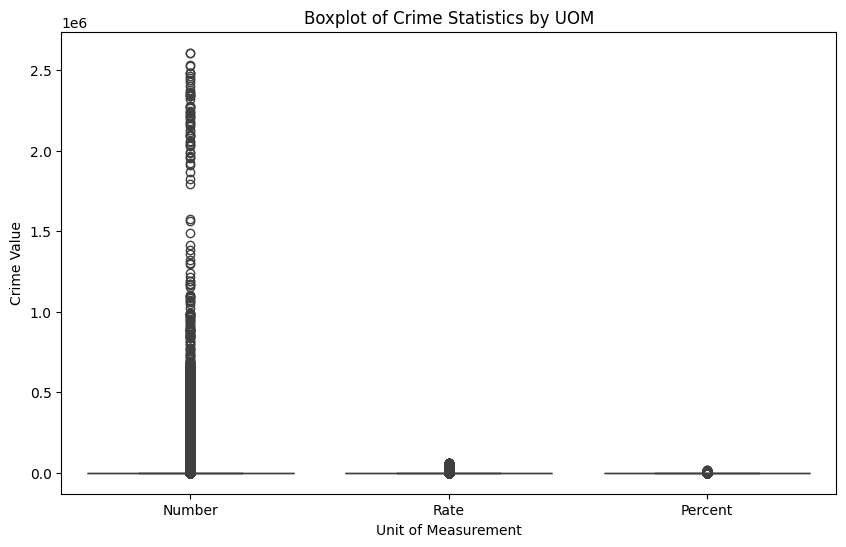

In [61]:
#Plotting box plot to detect outliers in the 'VALUE' column
plt.figure(figsize=(10, 6))
sns.boxplot(x='UOM', y='VALUE', data=Crime_Statistics)
plt.title('Boxplot of Crime Statistics by UOM')
plt.xlabel('Unit of Measurement')
plt.ylabel('Crime Value')
plt.show()

Outliers are detected in. the dataset. However, after careful consideration of the nature of the data, the decision was made not to remove the outliers.
 
The dataset contains crime statistics, and crime rates can vary significantly depending on the location, year, and type of crime. Removing outliers could lead to unreliable and incorrect conclusions, as these extreme values may represent real-world scenarios. Ignoring them would result in a loss of critical information.
 
Crime rates can naturally range from 0 to 100 or more, depending on the specific metric and location. These variations are expected and are reflective of the dataset's diversity. Since the goal is to analyze crime statistics comprehensively, retaining all data points ensures a complete and unbiased analysis. We will proceed with further data analysis using the full dataset, including outliers, to ensure the results reflect real-world variations.

## 10. Data Validation

In [62]:
#Counting the occurrences of 'yes' and 'no' in the TERMINATED column
TerminatedCounts = Crime_Statistics['TERMINATED'].value_counts()

#Printing the counts for 'yes' and 'no'
print("Distribution of TERMINATED Column (Yes/No):")
print(TerminatedCounts)

Distribution of TERMINATED Column (Yes/No):
TERMINATED
No    3615209
Name: count, dtype: int64


Before, the dataset initially included rows with both Terminate Status: Yes and No. Upon closer inspection, rows with Terminate Status: Yes corresponded to cases where the data was labeled as "not applicable". As all the rows with STATUS: .., which meant "Not Applicable" were removed, we are left only with rows where Terminate Status: No ensuring that the data retained is valid and applicable.

As, we only have one value "No" in TERMINATED column, we no longer need the column, so the best decision would be to drop this column.

In [63]:
#Dropping the column "TERMINATED"
Crime_Statistics.drop(['TERMINATED'], axis=1, inplace=True)

In [64]:
#Getting the top 10 violations for "Actual incidents"
CrimeStatisticsTopViolations = Crime_Statistics[(Crime_Statistics['Statistics'] == "Actual incidents") & 
                                                (Crime_Statistics['GEO'] == "Canada")]

#Grouping by 'Violations' and summing up 'VALUE'
CrimeStatisticsTopViolations = CrimeStatisticsTopViolations.groupby('Violations')['VALUE'].sum().reset_index()

#Excluding "Total, all violations [0]"
CrimeStatisticsTopViolations = CrimeStatisticsTopViolations[CrimeStatisticsTopViolations['Violations'] != "Total, all violations [0]"]

#Sorting violations by total number of incidents in descending order and getting the top 10
CrimeStatisticsTopViolations = CrimeStatisticsTopViolations.sort_values(by='VALUE', ascending=False).head(10)

#Displaying the top 10 violations
print("Top 10 Violations in Canada: ")
print(CrimeStatisticsTopViolations)

Top 10 Violations in Canada: 
                                            Violations       VALUE
293  Total, all Criminal Code violations (including...  42171493.0
292  Total, all Criminal Code violations (excluding...  39680568.0
280              Total property crime violations [200]  24421586.0
287  Total theft under $5,000 (non-motor vehicle) [...   9907157.0
290       Total violent Criminal Code violations [100]   8450906.0
271         Total other Criminal Code violations [300]   6808076.0
267                               Total mischief [250]   5938150.0
148                                    Mischief [2170]   5935699.0
246                       Theft $5,000 or under [2140]   4406743.0
255   Total administration of justice violations [330]   3653267.0


The dataset initially shows violations and their corresponding values, but upon inspection, it appears that the data contains a breakdown of violations into subcategories. Before moving forward with the analysis, it is important to first segregate the violations to ensure that we are working with the correct categorization.

This step is crucial as the violations are not always structured in a simple way (e.g., some violations may have additional breakdowns such as "Theft [123]" or "Violence [456]").

Once the violations are properly segregated and categorized, we can proceed with identifying the top 10 violations based on the total number of incidents. This segregation ensures that we are accurately representing the data and that our analysis is based on properly defined violation categories.

## 11. Violation Segregation

In [65]:
#Filtering the data to get rows where 'Violations' contains exactly 1 digit inside square brackets
FilteredViolation1 = Crime_Statistics[(Crime_Statistics['Violations'].str.contains(r'\[\d{1}\]', na=False)) & 
                                      (Crime_Statistics['Statistics'] == "Actual incidents") & 
                                      (Crime_Statistics['GEO'] == "Canada")]

#Grouping by 'Violations' and suming up the 'VALUE' for each violation
AllViolations1 = FilteredViolation1[FilteredViolation1['Statistics'] == "Actual incidents"] \
    .groupby(['Violations'])['VALUE'].sum().reset_index()

#Sorting violations by total number of incidents in descending order
AllViolations1 = AllViolations1.sort_values(by='VALUE', ascending=False)

#Expanding display settings to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust display width for better visibility

#Print the filtered violations
print("Filtered Violations in Canada with Values:")
print(AllViolations1)

Filtered Violations in Canada with Values:
                  Violations       VALUE
0  Total, all violations [0]  44409279.0


This is the overall total number of incidents for all violations in the dataset, grouped under the Violations column with the pattern [0].

In [66]:
#Filtering the data to get rows where 'Violations' contains exactly 2 digits inside square brackets
FilteredViolation2 = Crime_Statistics[(Crime_Statistics['Violations'].str.contains(r'\[\d{2}\]', na=False)) & 
                                      (Crime_Statistics['Statistics'] == "Actual incidents") & 
                                      (Crime_Statistics['GEO'] == "Canada")]

#Grouping by 'Violations' and suming up the 'VALUE' for each violation
AllViolations2 = FilteredViolation2[FilteredViolation2['Statistics'] == "Actual incidents"] \
    .groupby(['Violations'])['VALUE'].sum().reset_index()

#Sorting violations by total number of incidents in descending order
AllViolations2 = AllViolations2.sort_values(by='VALUE', ascending=False)

#Expanding display settings to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust display width for better visibility

#Print the filtered violations
print("Filtered Violations in Canada with Values:")
print(AllViolations2)

Filtered Violations in Canada with Values:
                                          Violations       VALUE
1  Total, all Criminal Code violations (including...  42171493.0
0  Total, all Criminal Code violations (excluding...  39680568.0


The following two entries represent the total number of incidents for Criminal Code violations:
- Total, all Criminal Code violations (including traffic) [25]
- Total, all Criminal Code violations (excluding traffic) [50]

These values provide a breakdown of incidents related to Criminal Code violations, one representing the overall total (All Criminal Offenses and All Criminal Traffic Violations) and the other representing the total including only Crimininal Offenses.

In [67]:
#Filtering the data to get rows where 'Violations' contains exactly 3 digits inside square brackets
FilteredViolation3 = Crime_Statistics[(Crime_Statistics['Violations'].str.contains(r'\[\d{3}\]', na=False)) & 
                                      (Crime_Statistics['Statistics'] == "Actual incidents") & 
                                      (Crime_Statistics['GEO'] == "Canada")]

#Grouping by 'Violations' and suming up the 'VALUE' for each violation
AllViolations3 = FilteredViolation3[FilteredViolation3['Statistics'] == "Actual incidents"] \
    .groupby(['Violations'])['VALUE'].sum().reset_index()

#Sorting violations by total number of incidents in descending order
AllViolations3 = AllViolations3.sort_values(by='VALUE', ascending=False)

#Expanding display settings to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust display width for better visibility

#Print the filtered violations
print("Filtered Violations in Canada with Values:")
print(AllViolations3)

Filtered Violations in Canada with Values:
                                           Violations       VALUE
31              Total property crime violations [200]  24421586.0
38  Total theft under $5,000 (non-motor vehicle) [...   9907157.0
41       Total violent Criminal Code violations [100]   8450906.0
22         Total other Criminal Code violations [300]   6808076.0
18                               Total mischief [250]   5938150.0
6    Total administration of justice violations [330]   3653267.0
8                   Total breaking and entering [210]   3353982.0
2        Total Criminal Code traffic violations [900]   2490925.0
3              Total Federal Statute violations [400]   2237786.0
36                 Total theft of motor vehicle [220]   1896087.0
12                        Total drug violations [401]   1710546.0
16                       Total impaired driving [910]   1480904.0
21  Total other Criminal Code traffic violations [...   1010021.0
13                 Total fail to 

After careful examination, we categorized the data as follows:

1. Total Violations from 2005 to 2023: The total reported violations in Canada from 2005 to 2023 amount to 44,409,279, which consists of

- Total, all Criminal Code violations (including traffic) [25] → 42,171,493
- Total Federal Statute violations [400] → 2,237,786

2. Breakdown of Total, all Criminal Code violations (including traffic) [25]: The 42,171,493 Total, all Criminal Code violations (including traffic) [25] include:

- Total, all Criminal Code violations (excluding traffic) [50] → 39,680,568
- Total Criminal Code traffic violations [900] → 2,490,925

3. Breakdown of Total, all Criminal Code violations (excluding traffic) [50]: The 39,680,568 Criminal Code violations (excluding traffic) include:

- Total violent Criminal Code violations [100] → 8,450,906
- Total property crime violations [200] → 24,421,586
- Total other Criminal Code violations [300] → 6,808,076

4. Breakdown of Total Criminal Code traffic violations [900]: The 2,490,925 Criminal Code traffic violations include:

- Total impaired driving [910] → 1,480,904
- Total other Criminal Code traffic violations [920] → 1,010,021

In [68]:
#Filtering the data for Total Violations in Canada
TotalAllViolations = Crime_Statistics[
    (Crime_Statistics['Violations'] == "Total, all violations [0]") & 
    (Crime_Statistics['Statistics'] == "Actual incidents") & 
    (Crime_Statistics['GEO'] == "Canada")
]

#Displaying total violations
TotalViolationsValue = TotalAllViolations['VALUE'].sum()

#Filtering data for various violation types
CriminalCodeViolationsIncludingTraffic = Crime_Statistics[
    (Crime_Statistics['Violations'] == "Total, all Criminal Code violations (including traffic) [25]") & 
    (Crime_Statistics['Statistics'] == "Actual incidents") & 
    (Crime_Statistics['GEO'] == "Canada")
]

FederalStatuteViolations = Crime_Statistics[
    (Crime_Statistics['Violations'] == "Total Federal Statute violations [400]") & 
    (Crime_Statistics['Statistics'] == "Actual incidents") & 
    (Crime_Statistics['GEO'] == "Canada")
]

CriminalCodeViolationsExcludingTraffic = Crime_Statistics[
    (Crime_Statistics['Violations'] == "Total, all Criminal Code violations (excluding traffic) [50]") & 
    (Crime_Statistics['Statistics'] == "Actual incidents") & 
    (Crime_Statistics['GEO'] == "Canada")
]

CriminalCodeTrafficViolations = Crime_Statistics[
    (Crime_Statistics['Violations'] == "Total Criminal Code traffic violations [900]") & 
    (Crime_Statistics['Statistics'] == "Actual incidents") & 
    (Crime_Statistics['GEO'] == "Canada")
]

ViolentCriminalCodeViolations = Crime_Statistics[
    (Crime_Statistics['Violations'] == "Total violent Criminal Code violations [100]") & 
    (Crime_Statistics['Statistics'] == "Actual incidents") & 
    (Crime_Statistics['GEO'] == "Canada")
]

PropertyCrimeViolations = Crime_Statistics[
    (Crime_Statistics['Violations'] == "Total property crime violations [200]") & 
    (Crime_Statistics['Statistics'] == "Actual incidents") & 
    (Crime_Statistics['GEO'] == "Canada")
]

OtherCriminalCodeViolations = Crime_Statistics[
    (Crime_Statistics['Violations'] == "Total other Criminal Code violations [300]") & 
    (Crime_Statistics['Statistics'] == "Actual incidents") & 
    (Crime_Statistics['GEO'] == "Canada")
]

ImpairedDrivingViolations = Crime_Statistics[
    (Crime_Statistics['Violations'] == "Total impaired driving [910]") & 
    (Crime_Statistics['Statistics'] == "Actual incidents") & 
    (Crime_Statistics['GEO'] == "Canada")
]

OtherCriminalCodeTrafficViolations = Crime_Statistics[
    (Crime_Statistics['Violations'] == "Total other Criminal Code traffic violations [920]") & 
    (Crime_Statistics['Statistics'] == "Actual incidents") & 
    (Crime_Statistics['GEO'] == "Canada")
]

#Extracting values for plotting
TotalViolationsValue = TotalAllViolations['VALUE'].sum()
CriminalCodeValueIncludingTraffic = CriminalCodeViolationsIncludingTraffic['VALUE'].sum()
FederalStatuteValue = FederalStatuteViolations['VALUE'].sum()
CriminalCodeValueExcludingTraffic = CriminalCodeViolationsExcludingTraffic['VALUE'].sum()
CriminalCodeTrafficValue = CriminalCodeTrafficViolations['VALUE'].sum()
ViolentCriminalCodeValue = ViolentCriminalCodeViolations['VALUE'].sum()
PropertyCrimeValue = PropertyCrimeViolations['VALUE'].sum()
OtherCriminalCodeValue = OtherCriminalCodeViolations['VALUE'].sum()
ImpairedDrivingValue = ImpairedDrivingViolations['VALUE'].sum()
OtherCriminalCodeTrafficValue = OtherCriminalCodeTrafficViolations['VALUE'].sum()

# Create the combined bar chart
labels = [
    "Total Violations",
    "Criminal Code Violations (Including Traffic)",
    "Federal Statute Violations",
    "Criminal Code Violations (Excluding Traffic)",
    "Criminal Code Traffic Violations",
    "Violent Criminal Code Violations",
    "Property Crime Violations",
    "Other Criminal Code Violations",
    "Impaired Driving Violations",
    "Other Criminal Code Traffic Violations"
]

values = [
    TotalViolationsValue,
    CriminalCodeValueIncludingTraffic,
    FederalStatuteValue,
    CriminalCodeValueExcludingTraffic,
    CriminalCodeTrafficValue,
    ViolentCriminalCodeValue,
    PropertyCrimeValue,
    OtherCriminalCodeValue,
    ImpairedDrivingValue,
    OtherCriminalCodeTrafficValue
]

In [69]:
# Labels for the Sankey diagram
labels = [
    "Total, all violations [0]",
    "Total, all Criminal Code violations (including traffic) [25]",
    "Total Federal Statute violations [400]",
    "Total, all Criminal Code violations (excluding traffic) [50]",
    "Total Criminal Code traffic violations [900]",
    "Total violent Criminal Code violations [100]",
    "Total property crime violations [200]",
    "Total other Criminal Code violations [300]",
    "Total impaired driving [910]",
    "Total other Criminal Code traffic violations [920]"
]

# Source and target indices for the Sankey diagram (which categories are flowing into which)
sources = [
    0,  # Total, all violations [0] -> Total, all Criminal Code violations (including traffic) [25]
    0,  # Total, all violations [0]-> Total Federal Statute violations [400]
    1,  # Total, all Criminal Code violations (including traffic) [25] -> Total, all Criminal Code violations (excluding traffic) [50]
    1,  # Total, all Criminal Code violations (including traffic) [25] -> Total Criminal Code traffic violations [900]
    3,  # Total, all Criminal Code violations (excluding traffic) [50] -> Total violent Criminal Code violations [100]
    3,  # Total, all Criminal Code violations (excluding traffic) [50] -> Total property crime violations [200]
    3,  # Total, all Criminal Code violations (excluding traffic) [50] -> Total other Criminal Code violations [300]
    4,  # Total Criminal Code traffic violations [900] -> Total impaired driving [910]
    4,  # Total Criminal Code traffic violations [900] -> Total other Criminal Code traffic violations [920]
]

# Target categories that these flows are going into
targets = [
    1,  # Total, all violations [0] -> Total, all Criminal Code violations (including traffic) [25]
    2,  # Total, all violations [0]-> Total Federal Statute violations [400]
    3,  # Total, all Criminal Code violations (including traffic) [25] -> Total, all Criminal Code violations (excluding traffic) [50]
    4,  # Total, all Criminal Code violations (including traffic) [25] -> Total Criminal Code traffic violations [900]
    5,  # Total, all Criminal Code violations (excluding traffic) [50] -> Total violent Criminal Code violations [100]
    6,  # Total, all Criminal Code violations (excluding traffic) [50] -> Total property crime violations [200]
    7,  # Total, all Criminal Code violations (excluding traffic) [50] -> Total other Criminal Code violations [300]
    8,  # Total Criminal Code traffic violations [900] -> Total impaired driving [910]
    9,  # Total Criminal Code traffic violations [900] -> Total other Criminal Code traffic violations [920]
]

# Values representing the size of each flow
values = [
    TotalViolationsValue,  # Total, all violations [0] -> Total, all Criminal Code violations (including traffic) [25]
    FederalStatuteValue,  # Total, all violations [0]-> Total Federal Statute violations [400]
    CriminalCodeValueExcludingTraffic,  # Total, all Criminal Code violations (including traffic) [25] -> Total, all Criminal Code violations (excluding traffic) [50]
    CriminalCodeTrafficValue,  # Total, all Criminal Code violations (including traffic) [25] -> Total Criminal Code traffic violations [900]
    ViolentCriminalCodeValue,  # Total, all Criminal Code violations (excluding traffic) [50] -> Total violent Criminal Code violations [100]
    PropertyCrimeValue,  # Total, all Criminal Code violations (excluding traffic) [50] -> Total property crime violations [200]
    OtherCriminalCodeValue,  # Total, all Criminal Code violations (excluding traffic) [50] -> Total other Criminal Code violations [300]
    ImpairedDrivingValue,  # Total Criminal Code traffic violations [900] -> Total impaired driving [910]
    OtherCriminalCodeTrafficValue  # Total Criminal Code traffic violations [900] -> Total other Criminal Code traffic violations [920]
]

# Create the Sankey diagram with vertical orientation
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="skyblue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(0, 255, 255, 0.4)"
    )
))

# Customize the layout for vertical view
fig.update_layout(
    title="Violation Breakdown Flow in Canada (2005-2023)",
    font=dict(size=12),
    width=1200,
    height=800,  # Adjusted height to fit the vertical view
    xaxis=dict(showgrid=False, zeroline=False),  # Hide x-axis gridlines for better view
    yaxis=dict(showgrid=False, zeroline=False),  # Hide y-axis gridlines for better view
)

# Show the Sankey diagram
fig.show()

### Let's proceed further on breaking down "Total violent Criminal code violations [100]"

## Breakdown of Violations  

I have already worked on breaking down the violations, and the process takes longer to execute. To avoid unnecessary delays, I have commented out the code for breaking down the violations.  

**If you need to run the breakdown again, kindly uncomment the relevant section in the code.**  

In [70]:
# #Filtering the data to get rows where 'Violations' starts with [1...]
# FilteredViolation100 = Crime_Statistics[(Crime_Statistics['Violations'].str.contains(r'\[1\d*\]', na=False)) & 
#                                          (Crime_Statistics['Statistics'] == "Actual incidents") & 
#                                          (Crime_Statistics['GEO'] == "Canada")].copy()  # Creating a copy to avoid SettingWithCopyWarning

# #Extracting the numeric part inside the brackets for sorting (ensure it's treated as an integer)
# FilteredViolation100['ViolationIdentifier'] = FilteredViolation100['Violations'].str.extract(r'\[(\d+)\]').astype(int)

# #Grouping by 'Violations' and summing up the 'VALUE' for each violation
# AllViolations100 = FilteredViolation100.groupby(['Violations', 'ViolationIdentifier'])['VALUE'].sum().reset_index()

# #Sorting violations by the numeric values inside the brackets (ViolationIdentifier) in ascending order
# AllViolations100 = AllViolations100.sort_values(by='ViolationIdentifier', ascending=True)

# #Creating a dictionary-like format for each violation with its corresponding total value
# ViolationDictionary100 = dict(zip(AllViolations100['Violations'], AllViolations100['VALUE']))

# #Printing the dictionary-style output with a comma after each value
# for i, (violation, total_value) in enumerate(ViolationDictionary100.items()):
#     total_value = int(total_value) if total_value.is_integer() else total_value
#     if i < len(ViolationDictionary100) - 1:
#         print(f'"{violation}": {total_value},')
#     else:
#         print(f'"{violation}": {total_value}')

In [71]:
# #Filtering the data to get rows where 'Violations' starts with [5...]
# FilteredViolation500 = Crime_Statistics[(Crime_Statistics['Violations'].str.contains(r'\[5\d*\]', na=False)) & 
#                                          (Crime_Statistics['Statistics'] == "Actual incidents") & 
#                                          (Crime_Statistics['GEO'] == "Canada")].copy()  # Creating a copy to avoid SettingWithCopyWarning

# #Extracting the numeric part inside the brackets for sorting (ensure it's treated as an integer)
# FilteredViolation500['ViolationIdentifier'] = FilteredViolation500['Violations'].str.extract(r'\[(\d+)\]').astype(int)

# #Grouping by 'Violations' and summing up the 'VALUE' for each violation
# AllViolations500 = FilteredViolation500.groupby(['Violations', 'ViolationIdentifier'])['VALUE'].sum().reset_index()

# #Sorting violations by the numeric values inside the brackets (ViolationIdentifier) in ascending order
# AllViolations500 = AllViolations500.sort_values(by='ViolationIdentifier', ascending=True)

# #Creating a dictionary-like format for each violation with its corresponding total value
# ViolationDictionary500 = dict(zip(AllViolations500['Violations'], AllViolations500['VALUE']))

# #Printing the dictionary-style output with a comma after each value
# for i, (violation, total_value) in enumerate(ViolationDictionary500.items()):
#     total_value = int(total_value) if total_value.is_integer() else total_value
#     if i < len(ViolationDictionary500) - 1:
#         print(f'"{violation}": {total_value},')
#     else:
#         print(f'"{violation}": {total_value}')

In [72]:
#Breaking violation for Total violent Criminal Code violations [100] >> 8450906
# Violation100 = {
#     # "Total violent Criminal Code violations [100]": 8450906,
#     "Homicide [110]": 12259,
#     "Total other violations causing death [120]": 2024,
#     "Total sexual violations against children [130]": 112783,
#     "Total assaults against a peace officer [135]": 214480,
#     "Total other assaults [140]": 50550,
#     "Total firearms, use of, discharge, pointing [150]": 50814,
#     "Total robbery [160]": 494749,
#     "Total abduction [170]": 7821,
#     "Total other violent violations [180]": 104589,
#     "Total offences in relation to sexual services [190]": 7747,
#     "Murder, first degree [1110]": 5477,
#     "Murder, second degree [1120]": 5394,
#     "Manslaughter [1130]": 1377,
#     "Infanticide [1140]": 11,
#     "Criminal negligence causing death [1150]": 1900,
#     "Other related violations causing death [1160]": 124,
#     "Attempted murder [1210]": 14592,
#     "Conspire to commit murder [1220]": 897,
#     "Sexual offence which occurred prior to January 4, 1983 [1300]": 3061,
#     "Sexual assault, level 3, aggravated [1310]": 2605,
#     "Sexual assault, level 2, weapon or bodily harm [1320]": 8608,
#     "Sexual assault, level 1 [1330]": 469315,
#     "Other sexual violations [1340]": 10307,
#     "Sexual interference [1345]": 77012,
#     "Invitation to sexual touching [1350]": 10226,
#     "Sexual exploitation [1355]": 3000,
#     "Sexual Exploitation of a person with a disability [1356]": 332,
#     "Incest [1360]": 2738,
#     "Corrupting morals of a child [1365]": 786,
#     "Making sexually explicit material available to children [1367]": 2651,
#     "Parent or guardian procuring sexual activity [1368]": 61,
#     "Householder permitting prohibited sexual activity [1369]": 45,
#     "Luring a child via a computer [1370]": 19362,
#     "Agreement or Arrangement - sexual offence against child [1371]": 406,
#     "Anal intercourse [1375]": 235,
#     "Bestiality, commit or compel person [1380]": 321,
#     "Bestiality in presence of, or incites, a child [1381]": 20,
#     "Voyeurism [1385]": 12962,
#     "Non-consensual distribution of intimate images [1390]": 16553,
#     "Assault, level 3, aggravated [1410]": 68564,
#     "Assault, level 2, weapon or bodily harm [1420]": 1072138,
#     "Assault, level 1 [1430]": 3348201,
#     "Unlawfully causing bodily harm [1440]": 6624,
#     "Discharge firearm with intent [1450]": 19137,
#     "Using firearm in commission of offence [1455]": 9300,
#     "Pointing a firearm [1457]": 22377,
#     "Criminal negligence causing bodily harm [1470]": 4820,
#     "Trap likely to or causing bodily harm [1475]": 84,
#     "Other assaults [1480]": 39106,
#     "Forcible confinement or kidnapping [1510]": 25568,
#     "Kidnapping [1515]": 4884,
#     "Forcible confinement [1516]": 43546,
#     "Hostage-taking [1520]": 347,
#     "Trafficking in persons [1525]": 3494,
#     "Abduction under the age 14, not parent or guardian [1530]": 2770,
#     "Abduction under the age 16 [1540]": 713,
#     "Removal of children from Canada [1545]": 172,
#     "Abduction under the age 14 contravening a custody order [1550]": 2640,
#     "Abduction under age 14, by parent or guardian [1560]": 1526,
#     "Robbery [1610]": 494508,
#     "Robbery to steal a firearm [1611]": 241,
#     "Extortion [1620]": 72099,
#     "Intimidation of a justice system participant or a journalist [1621]": 11434,
#     "Intimidation of a non-justice participant [1622]": 18454,
#     "Criminal harassment [1625]": 417862,
#     "Indecent/Harassing communications [1626]": 411564,
#     "Uttering threats [1627]": 1430483,
#     "Explosives causing death or bodily harm [1628]": 301,
#     "Arson, disregard for human life [1629]": 8437,
#     "Other violent violations [1630]": 16362,
#     "Failure to comply with mandatory safeguards in relation to medical assistance in dying [1631]": 47,
#     "Forging or destroying documents related to assistance requests with criminal intent [1632]": 303,
#     "Obtaining sexual services for consideration [1711]": 3984,
#     "Obtaining sexual services for consideration from person under the age of 18 years [1712]": 513,
#     "Receive material benefit from sexual services [1721]": 183,
#     "Receive material benefit from sexual services provided by person under the age of 18 years [1722]": 95,
#     "Procuring [1731]": 1885,
#     "Procuring a person under the age of 18 years [1732]": 825,
#     "Advertising sexual services [1740]": 262,
#     "Total forcible confinement or kidnapping [510]": 73998 #Adding [510] manually
# }

# TargetSum1 = 8450906

# #Function to find combinations that sum up to the target
# def find_combinations(violations_data, target_sum):
#     # Extract names and values as a list of tuples
#     violations = list(violations_data.items())
    
#     # Loop through all possible combinations
#     for r in range(1, len(violations) + 1):
#         for combination in itertools.combinations(violations, r):
#             total_value = sum([violation[1] for violation in combination])
#             if total_value == target_sum:
#                 return combination
#     return None

# #Finding combinations that sum up to TargetSum1
# Result1 = find_combinations(Violation100, TargetSum1)

# if Result1:
#     print(f"Found combination that sums to {TargetSum1}:")
#     for violation, value in Result1:
#         print(f"{violation}: {value}")
# else:
#     print(f"No combination of violations sums to {TargetSum1}.")

### Let's proceed further on breaking down "Total property crime violations [200]"

In [73]:
# #Filtering the data to get rows where 'Violations' starts with [2...]
# FilteredViolation200 = Crime_Statistics[(Crime_Statistics['Violations'].str.contains(r'\[2\d*\]', na=False)) & 
#                                          (Crime_Statistics['Statistics'] == "Actual incidents") & 
#                                          (Crime_Statistics['GEO'] == "Canada")].copy()  # Creating a copy to avoid SettingWithCopyWarning

# #Extracting the numeric part inside the brackets for sorting (ensure it's treated as an integer)
# FilteredViolation200['ViolationIdentifier'] = FilteredViolation200['Violations'].str.extract(r'\[(\d+)\]').astype(int)

# #Grouping by 'Violations' and summing up the 'VALUE' for each violation
# AllViolations200 = FilteredViolation200.groupby(['Violations', 'ViolationIdentifier'])['VALUE'].sum().reset_index()

# #Sorting violations by the numeric values inside the brackets (ViolationIdentifier) in ascending order
# AllViolations200 = AllViolations200.sort_values(by='ViolationIdentifier', ascending=True)

# #Creating a dictionary-like format for each violation with its corresponding total value
# ViolationDictionary200 = dict(zip(AllViolations200['Violations'], AllViolations200['VALUE']))

# #Printing the dictionary-style output with a comma after each value
# for i, (violation, total_value) in enumerate(ViolationDictionary200.items()):
#     total_value = int(total_value) if total_value.is_integer() else total_value
#     if i < len(ViolationDictionary200) - 1:
#         print(f'"{violation}": {total_value},')
#     else:
#         print(f'"{violation}": {total_value}')

In [74]:
# #Breaking violation for Total property crime violations [200] >> 24421586
# Violation200 = {
#     # "Total, all Criminal Code violations (including traffic) [25]": 42171493,
#     # "Total property crime violations [200]": 24421586,
#     "Total breaking and entering [210]": 3353982,
#     "Total possession of stolen property [211]": 464413,
#     "Total trafficking in stolen property [212]": 10814,
#     "Total theft of motor vehicle [220]": 1896087,
#     "Total theft over $5,000 (non-motor vehicle) [230]": 337865,
#     "Total theft under $5,000 (non-motor vehicle) [240]": 9907157,
#     "Total mischief [250]": 5938150,
#     "Arson [2110]": 199450,
#     "Breaking and entering [2120]": 3340557,
#     "Breaking and entering to steal a firearm [2121]": 8682,
#     "Break and enter to steal a firearm from a motor vehicle [2125]": 4743,
#     "Theft over $5,000 [2130]": 247077,
#     "Theft over $5,000 from a motor vehicle [2132]": 80640,
#     "Shoplifting over $5,000 [2133]": 10148,
#     "Theft $5,000 or under [2140]": 4406743,
#     "Theft $5,000 or under from a motor vehicle [2142]": 3594660,
#     "Shoplifting $5,000 or under [2143]": 1905754,
#     "Fraud [2160]": 2049349,
#     "Identity theft [2165]": 52623,
#     "Identity fraud [2166]": 210076,
#     "Mischief [2170]": 5935699,
#     "Mischief in relation to cultural property [2175]": 397,
#     "Hate-motivated mischief relating to property used by identifiable group [2176]": 1976,
#     "Mischief relating to war memorials [2177]": 78,
#     "Altering, removing or destroying Vehicle Identification Number (VIN) [2178]": 1620
# }

# TargetSum2 = 24421586

# #Function to find combinations that sum up to the target
# def find_combinations(violations_data, target_sum):
#     # Extract names and values as a list of tuples
#     violations = list(violations_data.items())
    
#     # Loop through all possible combinations
#     for r in range(1, len(violations) + 1):
#         for combination in itertools.combinations(violations, r):
#             total_value = sum([violation[1] for violation in combination])
#             if total_value == target_sum:
#                 return combination
#     return None

# #Finding combinations that sum up to TargetSum2
# Result2 = find_combinations(Violation200, TargetSum2)

# if Result2:
#     print(f"Found combination that sums to {TargetSum2}:")
#     for violation, value in Result2:
#         print(f"{violation}: {value}")
# else:
#     print(f"No combination of violations sums to {TargetSum2}.")

### Let's proceed further on breaking down "Total other Criminal Code violations [300]"

In [75]:
# #Filtering the data to get rows where 'Violations' starts with [3...]
# FilteredViolation300 = Crime_Statistics[(Crime_Statistics['Violations'].str.contains(r'\[3\d*\]', na=False)) & 
#                                          (Crime_Statistics['Statistics'] == "Actual incidents") & 
#                                          (Crime_Statistics['GEO'] == "Canada")].copy()  # Creating a copy to avoid SettingWithCopyWarning

# #Extracting the numeric part inside the brackets for sorting (ensure it's treated as an integer)
# FilteredViolation300['ViolationIdentifier'] = FilteredViolation300['Violations'].str.extract(r'\[(\d+)\]').astype(int)

# #Grouping by 'Violations' and summing up the 'VALUE' for each violation
# AllViolations300 = FilteredViolation300.groupby(['Violations', 'ViolationIdentifier'])['VALUE'].sum().reset_index()

# #Sorting violations by the numeric values inside the brackets (ViolationIdentifier) in ascending order
# AllViolations300 = AllViolations300.sort_values(by='ViolationIdentifier', ascending=True)

# #Creating a dictionary-like format for each violation with its corresponding total value
# ViolationDictionary300 = dict(zip(AllViolations300['Violations'], AllViolations300['VALUE']))

# #Printing the dictionary-style output with a comma after each value
# for i, (violation, total_value) in enumerate(ViolationDictionary300.items()):
#     total_value = int(total_value) if total_value.is_integer() else total_value
#     if i < len(ViolationDictionary300) - 1:
#         print(f'"{violation}": {total_value},')
#     else:
#         print(f'"{violation}": {total_value}')

In [76]:
# #Breaking violation for Total other Criminal Code violations [300]": 6808076 >> 6808076
# Violation300 = {
#     # "Total, all Criminal Code violations (including traffic) [25]": 42171493,
#     # "Total other Criminal Code violations [300]": 6808076,
#     "Total weapons violations [310]": 313197,
#     "Total prostitution [320]": 35071,
#     # "Total administration of justice violations [330]": 3653267,
#     "Total violations related to animal cruelty [335]": 2540,
#     "Total other violations [340]": 587490,
#     "Bawdy house [3110]": 1150,
#     "Living off the avails of prostitution of a person under age 18 [3115]": 432,
#     "Procuring [3120]": 2112,
#     "Obtains or communicates with a person under age 18 for purpose of sex [3125]": 976,
#     "Other prostitution [3130]": 29534,
#     "Public communication to sell sexual services [3140]": 396,
#     "Offences related to impeding traffic to buy or sell sexual services [3141]": 471,
#     "Betting house [3210]": 96,
#     "Gaming house [3220]": 840,
#     "Other violations related to gaming and betting [3230]": 1550,
#     "Common Bawdy House [3240]": 84,
#     "Offensive weapons, explosives [3310]": 3653,
#     "Offensive weapons, prohibited [3320]": 75,
#     "Offensive weapons, restricted [3330]": 43,
#     "Firearm transfers or serial numbers [3340]": 23,
#     "Other offensive weapons [3350]": 192,
#     "Weapons trafficking and Manufacturing [3365]": 2803,
#     "Weapons possession contrary to order [3370]": 20468,
#     "Possession of weapons [3375]": 256876,
#     "Unauthorized importing or exporting of weapons [3380]": 1100,
#     "Firearms documentation or administration [3390]": 7661,
#     "Unsafe storage of firearms [3395]": 20303,
#     "Fail to comply with order [3410]": 2092797,
#     "Counterfeiting [3420]": 15059,
#     "Disturb the peace [3430]": 2091854,
#     "Escape or helps to escape from lawful custody [3440]": 18521,
#     "Indecent acts [3450]": 91552,
#     "Possession of, or accessing child pornography [3455]": 50880,
#     "Making, or distribution of child pornography [3456]": 58718,
#     "Corrupting morals [3460]": 3397,
#     "Obstruct public or peace officer [3470]": 147706,
#     "Prisoner unlawfully at large [3480]": 59509,
#     "Trespass at night [3490]": 59404,
#     "Fail to appear [3510]": 526788,
#     "Breach of probation [3520]": 804671,
#     "Utter threats to property or animal [3540]": 61483,
#     "Advocating genocide [3550]": 68,
#     "Public incitement of hatred [3560]": 1109,
#     "Offences against public order (Part II Criminal Code) [3710]": 9572,
#     "Property or service for terrorist activity [3711]": 374,
#     "Freezing of property, disclosure or audit [3712]": 18,
#     "Participate in activity of terrorist group [3713]": 405,
#     "Facilitate terrorist activity [3714]": 108,
#     "Commission or instructing to carry out terrorist activity [3715]": 97,
#     "Harbour or conceal terrorist [3716]": 1,
#     "Hoax terrorism [3717]": 326,
#     "Advocating/Promoting terrorism offence [3718]": 89,
#     "Firearms and other offensive weapons (Part III Criminal Code) [3720]": 34260,
#     "Leaving Canada to participate in activity of terrorist group [3721]": 104,
#     "Leaving Canada to facilitate terrorist activity [3722]": 11,
#     "Leaving Canada to commit offence for terrorist group [3723]": 1,
#     "Leaving Canada to commit offence that is terrorist activity [3724]": 7,
#     "Concealing person who carried out terrorist activity that is a terrorism offence for which that person is liable to imprisonment for life [3725]": 0,
#     "Concealing person who carried out terrorist activity that is a terrorism offence for which that person is liable to any punishment other than life [3726]": 0,
#     "Concealing person who is likely to carry out terrorist activity [3727]": 0,
#     "Other violations against the administration of law and justice (Part IV Criminal Code) [3730]": 150981,
#     "Sexual offences, public morals and disorderly conduct (Part V Criminal Code) [3740]": 6618,
#     "Invasion of privacy (Part VI Criminal Code) [3750]": 978,
#     "Disorderly houses, gaming and betting [3760]": 0,
#     "Offences against the person and reputation (Part VIII Criminal Code) [3770]": 24009,
#     "Other offences against the person and reputation [3772]": 979,
#     "Offences against rights of property (Part IX Criminal Code) [3780]": 30411,
#     "Fraudulent transactions relating to contracts and trade (Part X Criminal Code) [3790]": 7413,
#     "Wilful and forbidden acts in respect of certain property (Part XI Criminal Code) [3810]": 38123,
#     "Wilful and forbidden acts in respect of certain material property [3811]": 738,
#     "Offences relating to currency (Part XII Criminal Code) [3820]": 2259,
#     "Proceeds of crime (Part XII.2 Criminal Code) [3825]": 6261,
#     "Attempts, conspiracies, accessories (Part XIII Criminal Code) [3830]": 6936,
#     "Instruct offence for criminal organization [3840]": 117,
#     "Commit offence for criminal organization [3841]": 135,
#     "Participate in activities of criminal organization [3842]": 661,
#     "Recruitment of members by a criminal organization [3843]": 7,
#     "All other Criminal Code (includes Part XII.1 Criminal Code) [3890]": 48903
# }

# TargetSum3 = 3653267

# #Function to find combinations that sum up to the target
# def find_combinations(violations_data, target_sum):
#     # Extract names and values as a list of tuples
#     violations = list(violations_data.items())
    
#     # Loop through all possible combinations
#     for r in range(1, len(violations) + 1):
#         for combination in itertools.combinations(violations, r):
#             total_value = sum([violation[1] for violation in combination])
#             if total_value == target_sum:
#                 return combination
#     return None

# #Finding combinations that sum up to TargetSum3
# Result3 = find_combinations(Violation300, TargetSum3)

# if Result3:
#     print(f"Found combination that sums to {TargetSum3}:")
#     for violation, value in Result3:
#         print(f"{violation}: {value}")
# else:
#     print(f"No combination of violations sums to {TargetSum3}.")

### Let's proceed further on breaking down "Total Federal Statute violations [400]"

In [77]:
# #Filtering the data to get rows where 'Violations' starts with [4...]
# FilteredViolation400 = Crime_Statistics[(Crime_Statistics['Violations'].str.contains(r'\[4\d*\]', na=False)) & 
#                                          (Crime_Statistics['Statistics'] == "Actual incidents") & 
#                                          (Crime_Statistics['GEO'] == "Canada")].copy()  # Creating a copy to avoid SettingWithCopyWarning

# #Extracting the numeric part inside the brackets for sorting (ensure it's treated as an integer)
# FilteredViolation400['ViolationIdentifier'] = FilteredViolation400['Violations'].str.extract(r'\[(\d+)\]').astype(int)

# #Grouping by 'Violations' and summing up the 'VALUE' for each violation
# AllViolations400 = FilteredViolation400.groupby(['Violations', 'ViolationIdentifier'])['VALUE'].sum().reset_index()

# #Sorting violations by the numeric values inside the brackets (ViolationIdentifier) in ascending order
# AllViolations400 = AllViolations400.sort_values(by='ViolationIdentifier', ascending=True)

# #Creating a dictionary-like format for each violation with its corresponding total value
# ViolationDictionary400 = dict(zip(AllViolations400['Violations'], AllViolations400['VALUE']))

# #Printing the dictionary-style output with a comma after each value
# for i, (violation, total_value) in enumerate(ViolationDictionary400.items()):
#     total_value = int(total_value) if total_value.is_integer() else total_value
#     if i < len(ViolationDictionary400) - 1:
#         print(f'"{violation}": {total_value},')
#     else:
#         print(f'"{violation}": {total_value}')

In [78]:
# #Filtering the data to get rows where 'Violations' starts with [6...]
# FilteredViolation600 = Crime_Statistics[(Crime_Statistics['Violations'].str.contains(r'\[6\d*\]', na=False)) & 
#                                          (Crime_Statistics['Statistics'] == "Actual incidents") & 
#                                          (Crime_Statistics['GEO'] == "Canada")].copy()  # Creating a copy to avoid SettingWithCopyWarning

# #Extracting the numeric part inside the brackets for sorting (ensure it's treated as an integer)
# FilteredViolation600['ViolationIdentifier'] = FilteredViolation600['Violations'].str.extract(r'\[(\d+)\]').astype(int)

# #Grouping by 'Violations' and summing up the 'VALUE' for each violation
# AllViolations600 = FilteredViolation600.groupby(['Violations', 'ViolationIdentifier'])['VALUE'].sum().reset_index()

# #Sorting violations by the numeric values inside the brackets (ViolationIdentifier) in ascending order
# AllViolations600 = AllViolations600.sort_values(by='ViolationIdentifier', ascending=True)

# #Creating a dictionary-like format for each violation with its corresponding total value
# ViolationDictionary600 = dict(zip(AllViolations600['Violations'], AllViolations600['VALUE']))

# #Printing the dictionary-style output with a comma after each value
# for i, (violation, total_value) in enumerate(ViolationDictionary600.items()):
#     total_value = int(total_value) if total_value.is_integer() else total_value
#     if i < len(ViolationDictionary600) - 1:
#         print(f'"{violation}": {total_value},')
#     else:
#         print(f'"{violation}": {total_value}')

In [79]:
# #Breaking violation for Total Federal Statute violations [400] >> 2237786
# Violation400 = {
#     # "Total Federal Statute violations [400]": 2237786,
#     "Total drug violations [401]": 1710546,
#     "Total, possession, other Controlled Drugs and Substances Act drugs [410]": 271742,
#     "Total cannabis, trafficking, production or distribution (pre-legalization) [420]": 197066,
#     "Total cocaine, trafficking, production or distribution [430]": 173500,
#     "Total other Controlled Drugs and Substances Act drugs, trafficking, production or distribution [440]": 172573,
#     "Total Cannabis Act [450]": 62031,
#     "Total possession - Cannabis Act [451]": 7406,
#     "Total distribution - Cannabis Act [452]": 4828,
#     "Total sale - Cannabis Act [453]": 4447,
#     "Total importation and exportation - Cannabis Act [454]": 39127,
#     "Total production - Cannabis Act [455]": 3698,
#     "Heroin, possession [4110]": 21835,
#     "Possession, cocaine [4120]": 145212,
#     "Other Controlled Drugs and Substances Act, possession [4130]": 135826,
#     "Possession, cannabis (pre-legalization) [4140]": 687952,
#     "Methamphetamines (crystal meth), possession [4150]": 91876,
#     "Methylenedioxyamphetamine (ecstasy), possession [4160]": 5118,
#     "Opioid (other than heroin), possession [4170]": 17087,
#     "Heroin, trafficking [4210]": 9807,
#     "Cocaine, trafficking [4220]": 166728,
#     "Other Controlled Drugs and Substances Act, trafficking [4230]": 82574,
#     "Cannabis, trafficking (pre-legalization) [4240]": 112515,
#     "Methamphetamines (crystal meth), trafficking [4250]": 29492,
#     "Methylenedioxyamphetamine (ecstasy), trafficking [4260]": 2380,
#     "Opioid (other than heroin), trafficking [4270]": 9314,
#     "Heroin, importation and exportation [4310]": 1642,
#     "Cocaine, importation and exportation [4320]": 6479,
#     "Other Controlled Drugs and Substances Act, importation and exportation [4330]": 29670,
#     "Cannabis, importation and exportation (pre-legalization) [4340]": 17034,
#     "Methamphetamines (crystal meth), importation and exportation [4350]": 2042,
#     "Methylenedioxyamphetamine (ecstasy), importation and exportation [4360]": 2304,
#     "Opioid (other than heroin), importation and exportation [4370]": 470,
#     "Heroin, production [4410]": 29,
#     "Cocaine, production [4420]": 293,
#     "Other Controlled Drugs and Substances Act, production [4430]": 1796,
#     "Cannabis, production (pre-legalization) [4440]": 67517,
#     "Methamphetamines (crystal meth), production [4450]": 878,
#     "Methylenedioxyamphetamine (ecstasy), production [4460]": 101,
#     "Opioid (other than heroin), production [4470]": 74,
#     "Possession, sale, etc., for use in production of or trafficking in substance [4590]": 470,
#     "Possession of illicit or over 30g dried cannabis (or equivalent) by adult [4911]": 4163,
#     "Possession of over 5g dried cannabis (or equivalent) by youth [4912]": 2607,
#     "Possession of budding or flowering plants, or more than four cannabis plants [4913]": 607,
#     "Possession of cannabis by organization [4914]": 29,
#     "Distribution to an organization, illicit or over 30g dried cannabis (or equivalent) by adult [4921]": 893,
#     "Distribution of cannabis to youth by adult [4922]": 574,
#     "Distribution to an organization or over 5g dried cannabis (or equivalent) by youth [4923]": 99,
#     "Distribution of budding or flowering plants, or more than four cannabis plants [4924]": 49,
#     "Distribution of cannabis by organization [4925]": 104,
#     "Possession of cannabis for purpose of distributing [4926]": 3109,
#     "Sale of cannabis to adult [4931]": 1245,
#     "Sale of cannabis to youth [4932]": 567,
#     "Sale of cannabis to an organization [4933]": 9,
#     "Possession of cannabis for purpose of selling [4934]": 2626,
#     "Importation and exportation of cannabis [4941]": 39040,
#     "Possession of cannabis for purpose of exportation [4942]": 87,
#     "Obtain, offer to obtain, alter or offer to alter cannabis [4951]": 130,
#     "Cultivate, propagate or harvest cannabis by adult [4952]": 3534,
#     "Cultivate, propagate or harvest cannabis by youth or organization [4953]": 34,
#     "Possess, produce, sell, distribute or import anything for use in production or distribution of illicit cannabis [4961]": 535,
#     "Use of young person in the commission of a cannabis offence [4971]": 315,
#     "Other Cannabis Act [4981]": 1675,
#     "Total other Federal Statutes [610]": 386908,
#     "Total Immigration and Refugee Protection Act [620]": 15464,
#     "Bankruptcy Act [6100]": 650,
#     "Income Tax Act [6150]": 550,
#     "Canada Shipping Act [6200]": 61463,
#     "Canada Health Act [6250]": 298,
#     "Customs Act [6300]": 68453,
#     "Competition Act [6350]": 35,
#     "Excise Act [6400]": 15655,
#     "Youth Criminal Justice Act [6450]": 140332,
#     "Firearms Act [6550]": 24803,
#     "National Defence Act [6560]": 765,
#     "Quarantine Act [6600]": 3739,
#     "Other federal statutes [6900]": 195019
# }

# TargetSum4 = 2237786

# #Function to find combinations that sum up to the target
# def find_combinations(violations_data, target_sum):
#     # Extract names and values as a list of tuples
#     violations = list(violations_data.items())
    
#     # Loop through all possible combinations
#     for r in range(1, len(violations) + 1):
#         for combination in itertools.combinations(violations, r):
#             total_value = sum([violation[1] for violation in combination])
#             if total_value == target_sum:
#                 return combination
#     return None

# #Finding combinations that sum up to TargetSum4
# Result4 = find_combinations(Violation400, TargetSum4)

# if Result4:
#     print(f"Found combination that sums to {TargetSum4}:")
#     for violation, value in Result4:
#         print(f"{violation}: {value}")
# else:
#     print(f"No combination of violations sums to {TargetSum4}.")

### Let's proceed further on breaking down "Total Criminal Code traffic violations [900]"

In [80]:
# #Filtering the data to get rows where 'Violations' starts with [9...]
# FilteredViolation900 = Crime_Statistics[(Crime_Statistics['Violations'].str.contains(r'\[9\d*\]', na=False)) & 
#                                          (Crime_Statistics['Statistics'] == "Actual incidents") & 
#                                          (Crime_Statistics['GEO'] == "Canada")].copy()  # Creating a copy to avoid SettingWithCopyWarning

# #Extracting the numeric part inside the brackets for sorting (ensure it's treated as an integer)
# FilteredViolation900['ViolationIdentifier'] = FilteredViolation900['Violations'].str.extract(r'\[(\d+)\]').astype(int)

# #Grouping by 'Violations' and summing up the 'VALUE' for each violation
# AllViolations900 = FilteredViolation900.groupby(['Violations', 'ViolationIdentifier'])['VALUE'].sum().reset_index()

# #Sorting violations by the numeric values inside the brackets (ViolationIdentifier) in ascending order
# AllViolations900 = AllViolations900.sort_values(by='ViolationIdentifier', ascending=True)

# #Creating a dictionary-like format for each violation with its corresponding total value
# ViolationDictionary900 = dict(zip(AllViolations900['Violations'], AllViolations900['VALUE']))

# #Printing the dictionary-style output with a comma after each value
# for i, (violation, total_value) in enumerate(ViolationDictionary900.items()):
#     total_value = int(total_value) if total_value.is_integer() else total_value
#     if i < len(ViolationDictionary900) - 1:
#         print(f'"{violation}": {total_value},')
#     else:
#         print(f'"{violation}": {total_value}')

In [81]:
# #Breaking violation for Total Criminal Code traffic violations [900] >> 2490925
# Violation900 = {
#     # "Total Criminal Code traffic violations [900]": 2490925,
#     # "Total impaired driving [910]": 1480904,
#     # "Total other Criminal Code traffic violations [920]": 1010021,
#     "Total fail to stop or remain [930]": 642317,
#     "Dangerous operation, causing death [9110]": 1973,
#     "Dangerous operation, causing bodily harm [9120]": 10004,
#     "Dangerous operation of motor vehicle, vessel or aircraft [9130]": 134140,
#     "Dangerous operation evading police, causing death [9131]": 33,
#     "Dangerous operation evading police, causing bodily harm [9132]": 490,
#     "Dangerous operation of motor vehicle evading police [9133]": 86705,
#     "Operation - low blood drug concentration [9205]": 59,
#     "Operation while impaired causing death (alcohol) [9210]": 2219,
#     "Operation while impaired causing death (alcohol and drugs) [9213]": 35,
#     "Operation while impaired causing death (drugs) [9215]": 107,
#     "Operation while impaired causing death (unspecified) [9217]": 28,
#     "Operation while impaired causing bodily harm (alcohol) [9220]": 12270,
#     "Operation while impaired causing bodily harm (alcohol and drugs) [9223]": 158,
#     "Operation while impaired causing bodily harm (drugs) [9225]": 415,
#     "Operation while impaired causing bodily harm (unspecified) [9227]": 105,
#     "Operation while impaired (alcohol) [9230]": 1302969,
#     "Operation while impaired (alcohol and drugs) [9233]": 26088,
#     "Operation while impaired (drugs) [9235]": 58436,
#     "Operation while impaired (unspecified) [9237]": 9133,
#     "Impaired operation, failure to provide breath sample [9240]": 46357,
#     "Failure to comply or refusal (drugs) [9245]": 247,
#     "Impaired operation, failure to provide blood sample [9250]": 1087,
#     "Failure to provide blood sample (drugs) [9255]": 55,
#     "Failure or refusal to comply with demand (alcohol) [9260]": 17560,
#     "Failure or refusal to comply with demand (alcohol and drugs) [9263]": 796,
#     "Failure or refusal to comply with demand (drugs) [9265]": 768,
#     "Failure or refusal to comply with demand (unspecified) [9267]": 1917,
#     "Failure or refusal to comply with demand, accident resulting in bodily harm (alcohol) [9270]": 69,
#     "Failure or refusal to comply with demand, accident resulting in bodily harm (alcohol and drugs) [9273]": 7,
#     "Failure or refusal to comply with demand, accident resulting in bodily harm (drugs) [9275]": 3,
#     "Failure or refusal to comply with demand, accident resulting in bodily harm (unspecified) [9277]": 5,
#     "Failure or refusal to comply with demand, accident resulting in death (alcohol) [9280]": 10,
#     "Failure or refusal to comply with demand, accident resulting in death (alcohol and drugs) [9283]": 1,
#     "Failure or refusal to comply with demand, accident resulting in death (drugs) [9285]": 0,
#     "Failure or refusal to comply with demand, accident resulting in death (unspecified) [9287]": 0,
#     "Driving while prohibited [9320]": 129774,
#     "Other Criminal Code traffic violations [9330]": 3012,
#     "Causing death by criminal negligence while street racing [9410]": 15,
#     "Causing bodily harm by criminal negligence while street racing [9420]": 35,
#     "Dangerous operation causing death while street racing [9430]": 20,
#     "Dangerous operation causing bodily harm while street racing [9440]": 49,
#     "Dangerous operation of motor vehicle while street racing [9450]": 1454
# }

# TargetSum9 = 2490925

# #Function to find combinations that sum up to the target
# def find_combinations(violations_data, target_sum):
#     # Extract names and values as a list of tuples
#     violations = list(violations_data.items())
    
#     # Loop through all possible combinations
#     for r in range(1, len(violations) + 1):
#         for combination in itertools.combinations(violations, r):
#             total_value = sum([violation[1] for violation in combination])
#             if total_value == target_sum:
#                 return combination
#     return None

# #Finding combinations that sum up to TargetSum4
# Result9 = find_combinations(Violation900, TargetSum9)

# if Result9:
#     print(f"Found combination that sums to {TargetSum9}:")
#     for violation, value in Result9:
#         print(f"{violation}: {value}")
# else:
#     print(f"No combination of violations sums to {TargetSum9}.")

### Violations Breakdown Process  

Our violations are divided into three categories: **Violations Type, Main Violations, and Sub-Violations**.  

#### Step 1: Keeping Only Sub-Violations  
To begin, we will filter the dataset to retain only the **Sub-Violations**.  

#### Step 2: Assigning Main Violations
Once the dataset contains only **Sub-Violations**, we will systematically assign each one to its corresponding **Main Violations**.

#### Step 3: Assigning Violations Type  
Once the dataset contains **Sub-Violations and Main Violations**, we will systematically assign each one to its corresponding **Violations Type** simultaneously.

In [82]:
#Creating a copy of the original dataset
Crime_Statistics_Copy = Crime_Statistics.copy()

In [83]:
#Listing specific violations to keep
SubViolations = [
    "Murder, first degree [1110]",
    "Murder, second degree [1120]",
    "Manslaughter [1130]",
    "Infanticide [1140]",
    "Criminal negligence causing death [1150]",
    "Other related violations causing death [1160]",
    "Sexual interference [1345]",
    "Invitation to sexual touching [1350]",
    "Sexual exploitation [1355]",
    "Making sexually explicit material available to children [1367]",
    "Parent or guardian procuring sexual activity [1368]",
    "Householder permitting prohibited sexual activity [1369]",
    "Luring a child via a computer [1370]",
    "Agreement or Arrangement - sexual offence against child [1371]",
    "Bestiality in presence of, or incites, a child [1381]",
    "Total assaults against a peace officer [135]",
    "Unlawfully causing bodily harm [1440]",
    "Criminal negligence causing bodily harm [1470]",
    "Other assaults [1480]",
    "Discharge firearm with intent [1450]",
    "Using firearm in commission of offence [1455]",
    "Pointing a firearm [1457]",
    "Robbery [1610]",
    "Robbery to steal a firearm [1611]",
    "Abduction under the age 14, not parent or guardian [1530]",
    "Abduction under the age 16 [1540]",
    "Removal of children from Canada [1545]",
    "Abduction under the age 14 contravening a custody order [1550]",
    "Abduction under age 14, by parent or guardian [1560]",
    "Total other violent violations [180]",
    "Obtaining sexual services for consideration [1711]",
    "Obtaining sexual services for consideration from person under the age of 18 years [1712]",
    "Receive material benefit from sexual services [1721]",
    "Receive material benefit from sexual services provided by person under the age of 18 years [1722]",
    "Procuring [1731]",
    "Procuring a person under the age of 18 years [1732]",
    "Advertising sexual services [1740]",
    "Forcible confinement or kidnapping [1510]",
    "Kidnapping [1515]",
    "Forcible confinement [1516]",
    "Attempted murder [1210]",
    "Sexual offence which occurred prior to January 4, 1983 [1300]",
    "Sexual assault, level 3, aggravated [1310]",
    "Sexual assault, level 2, weapon or bodily harm [1320]",
    "Sexual assault, level 1 [1330]",
    "Assault, level 3, aggravated [1410]",
    "Assault, level 2, weapon or bodily harm [1420]",
    "Assault, level 1 [1430]",
    "Extortion [1620]",
    "Criminal harassment [1625]",
    "Indecent/Harassing communications [1626]",
    "Uttering threats [1627]",
    "Breaking and entering [2120]",
    "Breaking and entering to steal a firearm [2121]",
    "Break and enter to steal a firearm from a motor vehicle [2125]",
    "Total possession of stolen property [211]",
    "Total trafficking in stolen property [212]",
    "Total theft of motor vehicle [220]",
    "Theft over $5,000 [2130]",
    "Theft over $5,000 from a motor vehicle [2132]",
    "Shoplifting over $5,000 [2133]",
    "Theft $5,000 or under [2140]",
    "Theft $5,000 or under from a motor vehicle [2142]",
    "Shoplifting $5,000 or under [2143]",
    "Mischief [2170]",
    "Mischief in relation to cultural property [2175]",
    "Hate-motivated mischief relating to property used by identifiable group [2176]",
    "Mischief relating to war memorials [2177]",
    "Arson [2110]",
    "Fraud [2160]",
    "Identity theft [2165]",
    "Identity fraud [2166]",
    "Altering, removing or destroying Vehicle Identification Number (VIN) [2178]",
    "Offensive weapons, explosives [3310]",
    "Offensive weapons, prohibited [3320]",
    "Offensive weapons, restricted [3330]",
    "Firearm transfers or serial numbers [3340]",
    "Other offensive weapons [3350]",
    "Weapons trafficking and Manufacturing [3365]",
    "Weapons possession contrary to order [3370]",
    "Possession of weapons [3375]",
    "Unauthorized importing or exporting of weapons [3380]",
    "Firearms documentation or administration [3390]",
    "Unsafe storage of firearms [3395]",
    "Bawdy house [3110]",
    "Living off the avails of prostitution of a person under age 18 [3115]",
    "Procuring [3120]",
    "Obtains or communicates with a person under age 18 for purpose of sex [3125]",
    "Other prostitution [3130]",
    "Public communication to sell sexual services [3140]",
    "Offences related to impeding traffic to buy or sell sexual services [3141]",
    "Fail to comply with order [3410]",
    "Escape or helps to escape from lawful custody [3440]",
    "Prisoner unlawfully at large [3480]",
    "Fail to appear [3510]",
    "Breach of probation [3520]",
    "Other violations against the administration of law and justice (Part IV Criminal Code) [3730]",
    "Total violations related to animal cruelty [335]",
    "Total other violations [340]",
    "Counterfeiting [3420]",
    "Disturb the peace [3430]",
    "Possession of, or accessing child pornography [3455]",
    "Making, or distribution of child pornography [3456]",
    "Heroin, possession [4110]",
    "Other Controlled Drugs and Substances Act, possession [4130]",
    "Methamphetamines (crystal meth), possession [4150]",
    "Methylenedioxyamphetamine (ecstasy), possession [4160]",
    "Opioid (other than heroin), possession [4170]",
    "Cannabis, trafficking (pre-legalization) [4240]",
    "Cannabis, importation and exportation (pre-legalization) [4340]",
    "Cannabis, production (pre-legalization) [4440]",
    "Cocaine, trafficking [4220]",
    "Cocaine, importation and exportation [4320]",
    "Cocaine, production [4420]",
    "Heroin, trafficking [4210]",
    "Other Controlled Drugs and Substances Act, trafficking [4230]",
    "Methamphetamines (crystal meth), trafficking [4250]",
    "Methylenedioxyamphetamine (ecstasy), trafficking [4260]",
    "Opioid (other than heroin), trafficking [4270]",
    "Heroin, importation and exportation [4310]",
    "Other Controlled Drugs and Substances Act, importation and exportation [4330]",
    "Methamphetamines (crystal meth), importation and exportation [4350]",
    "Methylenedioxyamphetamine (ecstasy), importation and exportation [4360]",
    "Opioid (other than heroin), importation and exportation [4370]",
    "Heroin, production [4410]",
    "Other Controlled Drugs and Substances Act, production [4430]",
    "Methamphetamines (crystal meth), production [4450]",
    "Methylenedioxyamphetamine (ecstasy), production [4460]",
    "Opioid (other than heroin), production [4470]",
    "Possession of illicit or over 30g dried cannabis (or equivalent) by adult [4911]",
    "Possession of over 5g dried cannabis (or equivalent) by youth [4912]",
    "Possession of budding or flowering plants, or more than four cannabis plants [4913]",
    "Possession of cannabis by organization [4914]",
    "Distribution to an organization, illicit or over 30g dried cannabis (or equivalent) by adult [4921]",
    "Distribution of cannabis to youth by adult [4922]",
    "Distribution to an organization or over 5g dried cannabis (or equivalent) by youth [4923]",
    "Distribution of budding or flowering plants, or more than four cannabis plants [4924]",
    "Distribution of cannabis by organization [4925]",
    "Possession of cannabis for purpose of distributing [4926]",
    "Sale of cannabis to adult [4931]",
    "Sale of cannabis to youth [4932]",
    "Sale of cannabis to an organization [4933]",
    "Possession of cannabis for purpose of selling [4934]",
    "Importation and exportation of cannabis [4941]",
    "Possession of cannabis for purpose of exportation [4942]",
    "Obtain, offer to obtain, alter or offer to alter cannabis [4951]",
    "Cultivate, propagate or harvest cannabis by adult [4952]",
    "Cultivate, propagate or harvest cannabis by youth or organization [4953]",
    "Possess, produce, sell, distribute or import anything for use in production or distribution of illicit cannabis [4961]",
    "Use of young person in the commission of a cannabis offence [4971]",
    "Other Cannabis Act [4981]",
    "Possession, cocaine [4120]",
    "Possession, cannabis (pre-legalization) [4140]",
    "Possession, sale, etc., for use in production of or trafficking in substance [4590]",
    "Operation - low blood drug concentration [9205]",
    "Operation while impaired causing death (alcohol) [9210]",
    "Operation while impaired causing death (alcohol and drugs) [9213]",
    "Operation while impaired causing death (drugs) [9215]",
    "Operation while impaired causing death (unspecified) [9217]",
    "Operation while impaired causing bodily harm (alcohol) [9220]",
    "Operation while impaired causing bodily harm (alcohol and drugs) [9223]",
    "Operation while impaired causing bodily harm (drugs) [9225]",
    "Operation while impaired causing bodily harm (unspecified) [9227]",
    "Operation while impaired (alcohol) [9230]",
    "Operation while impaired (alcohol and drugs) [9233]",
    "Operation while impaired (drugs) [9235]",
    "Operation while impaired (unspecified) [9237]",
    "Impaired operation, failure to provide breath sample [9240]",
    "Failure to comply or refusal (drugs) [9245]",
    "Impaired operation, failure to provide blood sample [9250]",
    "Failure to provide blood sample (drugs) [9255]",
    "Failure or refusal to comply with demand (alcohol) [9260]",
    "Failure or refusal to comply with demand (alcohol and drugs) [9263]",
    "Failure or refusal to comply with demand (drugs) [9265]",
    "Failure or refusal to comply with demand (unspecified) [9267]",
    "Failure or refusal to comply with demand, accident resulting in bodily harm (alcohol) [9270]",
    "Failure or refusal to comply with demand, accident resulting in bodily harm (alcohol and drugs) [9273]",
    "Failure or refusal to comply with demand, accident resulting in bodily harm (drugs) [9275]",
    "Failure or refusal to comply with demand, accident resulting in bodily harm (unspecified) [9277]",
    "Failure or refusal to comply with demand, accident resulting in death (alcohol) [9280]",
    "Failure or refusal to comply with demand, accident resulting in death (alcohol and drugs) [9283]",
    "Failure or refusal to comply with demand, accident resulting in death (drugs) [9285]",
    "Failure or refusal to comply with demand, accident resulting in death (unspecified) [9287]",
    "Total fail to stop or remain [930]",
    "Dangerous operation, causing death [9110]",
    "Dangerous operation, causing bodily harm [9120]",
    "Dangerous operation of motor vehicle, vessel or aircraft [9130]",
    "Dangerous operation evading police, causing death [9131]",
    "Dangerous operation evading police, causing bodily harm [9132]",
    "Dangerous operation of motor vehicle evading police [9133]",
    "Driving while prohibited [9320]",
    "Other Criminal Code traffic violations [9330]",
    "Causing death by criminal negligence while street racing [9410]",
    "Causing bodily harm by criminal negligence while street racing [9420]",
    "Dangerous operation causing death while street racing [9430]",
    "Dangerous operation causing bodily harm while street racing [9440]",
    "Dangerous operation of motor vehicle while street racing [9450]",
    "Total other Federal Statutes [610]",
    "Youth Criminal Justice Act [6450]"
]

In [84]:
#Filtering dataset to include only rows with sub-violations in the list
Crime_Statistics_Copy = Crime_Statistics[Crime_Statistics['Violations'].isin(SubViolations)]

#Confirming the first 20 rows of the filtered dataset
Crime_Statistics_Copy.head(20)

Year     GEO                    Violations                                         Statistics      UOM       VECTOR COORDINATE   VALUE
1875406  2005  Canada   Murder, first degree [1110]                                   Actual incidents   Number    v44391126      1.6.1  313.00
1875407  2005  Canada   Murder, first degree [1110]                        Rate per 100,000 population     Rate    v44347387      1.6.2    0.97
1875408  2005  Canada   Murder, first degree [1110]                          Percentage change in rate  Percent    v44332852      1.6.3   -6.05
1875409  2005  Canada   Murder, first degree [1110]  Percentage contribution to the Crime Severity ...  Percent  v1545644865     1.6.17    1.21
1875412  2005  Canada   Murder, first degree [1110]                                      Total cleared   Number    v44388137      1.6.4  191.00
1875413  2005  Canada   Murder, first degree [1110]                                  Cleared by charge   Number    v44345706      1.6.5  152.00
1875414  2005  Canada   Murder, first degree [1110]                                  Cleared otherwise   Number    v44410846      1.6.6   39.00
1875415  2005  Canada   Murder, first degree [1110]                             Total, persons charged   Number    v44343383      1.6.7  230.00
1875416  2005  Canada   Murder, first degree [1110]  Rate, total persons charged per 100,000 popula...     Rate    v44393963      1.6.8    0.83
1875417  2005  Canada   Murder, first degree [1110]                               Total, adult charged   Number    v44376857      1.6.9  208.00
1875418  2005  Canada   Murder, first degree [1110]  Rate, adult charged per 100,000 population age...     Rate    v44375426     1.6.10    0.82
1875419  2005  Canada   Murder, first degree [1110]                               Total, youth charged   Number    v44381849     1.6.11   22.00
1875420  2005  Canada   Murder, first degree [1110]  Rate, youth charged per 100,000 population age...     Rate    v44351211     1.6.12    0.84
1875421  2005  Canada   Murder, first degree [1110]                           Total, youth not charged   Number    v53080919     1.6.13    0.00
1875422  2005  Canada   Murder, first degree [1110]  Rate, youth not charged per 100,000 population...     Rate    v53080920     1.6.14    0.00
1875423  2005  Canada  Murder, second degree [1120]                                   Actual incidents   Number    v44413894      1.7.1  279.00
1875424  2005  Canada  Murder, second degree [1120]                        Rate per 100,000 population     Rate    v44358254      1.7.2    0.87
1875425  2005  Canada  Murder, second degree [1120]                          Percentage change in rate  Percent    v44366594      1.7.3   26.19
1875426  2005  Canada  Murder, second degree [1120]  Percentage contribution to the Crime Severity ...  Percent  v1545644876     1.7.17    1.08
1875429  2005  Canada  Murder, second degree [1120]                                      Total cleared   Number    v44376764      1.7.4  243.00

In [85]:
#Defining a dictionary with the mappings
MappingViolations = {
    'Homicide [110]': ['Murder, first degree [1110]', 'Murder, second degree [1120]', 'Manslaughter [1130]', 'Infanticide [1140]'],
    'Total, other violations causing death [120]': ['Criminal negligence causing death [1150]', 'Other related violations causing death [1160]'],
    'Total sexual violations against children [130]': ['Sexual interference [1345]', 'Invitation to sexual touching [1350]', 'Sexual exploitation [1355]', 'Making sexually explicit material available to children [1367]',
                                                     'Parent or guardian procuring sexual activity [1368]', 'Householder permitting prohibited sexual activity [1369]', 'Luring a child via a computer [1370]',
                                                     'Agreement or Arrangement - sexual offence against child [1371]', 'Bestiality in presence of, or incites, a child [1381]'],
    'Total other assaults [140]': ['Unlawfully causing bodily harm [1440]', 'Criminal negligence causing bodily harm [1470]', 'Other assaults [1480]'],
    'Total firearms, use of, discharge, pointing [150]': ['Discharge firearm with intent [1450]', 'Using firearm in commission of offence [1455]', 'Pointing a firearm [1457]'],
    'Total Robbery [160]': ['Robbery [1610]', 'Robbery to steal a firearm [1611]'],
    'Total Abduction [170]': ['Abduction under the age 14, not parent or guardian [1530]', 'Abduction under the age 16 [1540]', 'Removal of children from Canada [1545]',
                               'Abduction under the age 14 contravening a custody order [1550]', 'Abduction under age 14, by parent or guardian [1560]'],
    'Total offences in relation to sexual services [190]': ['Obtaining sexual services for consideration [1711]', 'Obtaining sexual services for consideration from person under the age of 18 years [1712]',
                                                           'Receive material benefit from sexual services [1721]', 'Receive material benefit from sexual services provided by person under the age of 18 years [1722]',
                                                           'Procuring [1731]', 'Procuring a person under the age of 18 years [1732]', 'Advertising sexual services [1740]'],
    'Total forcible confinement or kidnapping [510]': ['Forcible confinement or kidnapping [1510]', 'Kidnapping [1515]', 'Forcible confinement [1516]'],
    'Total breaking and entering [210]': ['Breaking and entering [2120]', 'Breaking and entering to steal a firearm [2121]', 'Break and enter to steal a firearm from a motor vehicle [2125]'],
    'Total theft over $5,000 (non-motor vehicle) [230]': ['Theft over $5,000 [2130]', 'Theft over $5,000 from a motor vehicle [2132]', 'Shoplifting over $5,000 [2133]'],
    'Total theft under $5,000 (non-motor vehicle) [240]': ['Theft $5,000 or under [2140]', 'Theft $5,000 or under from a motor vehicle [2142]', 'Shoplifting $5,000 or under [2143]'],
    'Total mischief [250]': ['Mischief [2170]', 'Mischief in relation to cultural property [2175]', 'Hate-motivated mischief relating to property used by identifiable group [2176]', 'Mischief relating to war memorials [2177]'],
    'Total weapons violations [310]': ['Offensive weapons, explosives [3310]', 'Offensive weapons, prohibited [3320]', 'Offensive weapons, restricted [3330]',
                                       'Firearm transfers or serial numbers [3340]', 'Other offensive weapons [3350]', 'Weapons trafficking and Manufacturing [3365]',
                                       'Weapons possession contrary to order [3370]', 'Possession of weapons [3375]', 'Unauthorized, importing or exporting of weapons [3380]',
                                       'Firearms documentation or administration [3390]', 'Unsafe storage of firearms [3395]'],
    'Total prostitution [320]': ['Bawdy house [3110]', 'Living off the avails of prostitution of a person under age 18 [3115]', 'Procuring [3120]',
                                 'Obtains or communicates with a person under age 18 for purpose of sex [3125]', 'Other prostitution [3130]', 'Public communication to sell sexual services [3140]',
                                 'Offences related to impeding traffic to buy or sell sexual services [3141]'],
    'Total administration of justice violations [330]': ['Fail to comply with order [3410]', 'Escape or helps to escape from lawful custody [3440]', 'Prisoner unlawfully at large [3480]',
                                                        'Fail to appear [3510]', 'Breach of probation [3520]', 'Other violations against the administration of law and justice (Part IV Criminal Code) [3730]'],
    'Total impaired driving [910]': ['Operation - low blood drug concentration [9205]', 'Operation while impaired causing death (alcohol) [9210]', 'Operation while impaired causing death (alcohol and drugs) [9213]',
                                    'Operation while impaired causing death (drugs) [9215]', 'Operation while impaired causing death (unspecified) [9217]',
                                    'Operation while impaired causing bodily harm (alcohol) [9220]', 'Operation while impaired causing bodily harm (alcohol and drugs) [9223]',
                                    'Operation while impaired causing bodily harm (drugs) [9225]', 'Operation while impaired causing bodily harm (unspecified) [9227]',
                                    'Operation while impaired (alcohol) [9230]', 'Operation while impaired (alcohol and drugs) [9233]', 'Operation while impaired (drugs) [9235]',
                                    'Operation while impaired (unspecified) [9237]', 'Impaired operation, failure to provide breath sample [9240]', 'Failure to comply or refusal (drugs) [9245]',
                                    'Impaired operation, failure to provide blood sample [9250]', 'Failure to provide blood sample (drugs) [9255]',
                                    'Failure or refusal to comply with demand (alcohol) [9260]', 'Failure or refusal to comply with demand (alcohol and drugs) [9263]',
                                    'Failure or refusal to comply with demand (drugs) [9265]', 'Failure or refusal to comply with demand (unspecified) [9267]',
                                    'Failure or refusal to comply with demand, accident resulting in bodily harm (alcohol) [9270]', 'Failure or refusal to comply with demand, accident resulting in bodily harm (alcohol and drugs) [9273]',
                                    'Failure or refusal to comply with demand, accident resulting in bodily harm (drugs) [9275]', 'Failure or refusal to comply with demand, accident resulting in bodily harm (unspecified) [9277]',
                                    'Failure or refusal to comply with demand, accident resulting in death (alcohol) [9280]', 'Failure or refusal to comply with demand, accident resulting in death (alcohol and drugs) [9283]',
                                    'Failure or refusal to comply with demand, accident resulting in death (drugs) [9285]', 'Failure or refusal to comply with demand, accident resulting in death (unspecified) [9287]'],
    'Total other Criminal Code traffic violations [920]': ['Total fail to stop or remain [930]', 'Dangerous operation, causing death [9110]', 'Dangerous operation, causing bodily harm [9120]',
                                                            'Dangerous operation of motor vehicle, vessel or aircraft [9130]', 'Dangerous operation evading police, causing death [9131]',
                                                            'Dangerous operation evading police, causing bodily harm [9132]', 'Dangerous operation of motor vehicle evading police [9133]',
                                                            'Driving while prohibited [9320]', 'Other Criminal Code traffic violations [9330]',
                                                            'Causing death by criminal negligence while street racing [9410]', 'Causing bodily harm by criminal negligence while street racing [9420]',
                                                            'Dangerous operation causing death while street racing [9430]', 'Dangerous operation causing bodily harm while street racing [9440]',
                                                            'Dangerous operation of motor vehicle while street racing [9450]'],
    'Total other Controlled Drugs and Substances Act drugs, trafficking, production or distribution [440]': ['Heroin, trafficking [4210]', 'Other Controlled Drugs and Substances Act, trafficking [4230]',
                                                                                                              'Methamphetamines (crystal meth), trafficking [4250]', 'Methylenedioxyamphetamine (ecstasy), trafficking [4260]',
                                                                                                              'Opioid (other than heroin), trafficking [4270]', 'Heroin, importation and exportation [4310]',
                                                                                                              'Other Controlled Drugs and Substances Act, importation and exportation [4330]', 'Methamphetamines (crystal meth), importation and exportation [4350]',
                                                                                                              'Methylenedioxyamphetamine (ecstasy), importation and exportation [4360]', 'Opioid (other than heroin), importation and exportation [4370]',
                                                                                                              'Heroin, production [4410]', 'Other Controlled Drugs and Substances Act, production [4430]',
                                                                                                              'Methamphetamines (crystal meth), production [4450]', 'Methylenedioxyamphetamine (ecstasy), production [4460]',
                                                                                                              'Opioid (other than heroin), production [4470]'],
    'Total cocaine, trafficking, production or distribution [430]': ['Cocaine, trafficking [4220]', 'Cocaine, importation and exportation [4320]', 'Cocaine, production [4420]'],
    'Total cannabis, trafficking, production or distribution (pre-legalization) [420]': ['Cannabis, trafficking (pre-legalization) [4240]', 'Cannabis, importation and exportation (pre-legalization) [4340]', 
                                                                                         'Cannabis, production (pre-legalization) [4440]'],
    'Total, possession, other Controlled Drugs and Substances Act drugs [410]': ['Heroin, possession [4110]', 'Other Controlled Drugs and Substances Act, possession [4130]',
                                                                                 'Methamphetamines (crystal meth), possession [4150]', 'Methylenedioxyamphetamine (ecstasy), possession [4160]',
                                                                                 'Opioid (other than heroin), possession [4170]'],
    'Total possession - Cannabis Act [451]': ['Possession of illicit or over 30g dried cannabis (or equivalent) by adult [4911]', 'Possession of over 5g dried cannabis (or equivalent) by youth [4912]',
                                              'Possession of budding or flowering plants, or more than four cannabis plants [4913]', 'Possession of cannabis by organization [4914]'],
    'Total distribution - Cannabis Act [452]': [ 'Distribution to an organization, illicit or over 30g dried cannabis (or equivalent) by adult [4921]', 'Distribution of cannabis to youth by adult [4922]',
                                                'Distribution to an organization or over 5g dried cannabis (or equivalent) by youth [4923]', 'Distribution of budding or flowering plants, or more than four cannabis plants [4924]',
                                                'Distribution of cannabis by organization [4925]', 'Possession of cannabis for purpose of distributing [4926]'
                                                ],
    'Total sale - Cannabis Act [453]': ['Sale of cannabis to adult [4931]', 'Sale of cannabis to youth [4932]', 'Sale of cannabis to an organization [4933]',
                                        'Possession of cannabis for purpose of selling [4934]'],
    'Total importation and exportation - Cannabis Act [454]': ['Importation and exportation of cannabis [4941]', 'Possession of cannabis for purpose of exportation [4942]'
                                                               ],
    'Total production - Cannabis Act [455]': ['Obtain, offer to obtain, alter or offer to alter cannabis [4951]', 'Cultivate, propagate or harvest cannabis by adult [4952]', 
                                              'Cultivate, propagate or harvest cannabis by youth or organization [4953]']
}

#Creating a reverse mapping dictionary for faster lookups
ReverseMapping = {}
for main_violation, sub_violations in MappingViolations.items():
    for sub_violation in sub_violations:
        ReverseMapping[sub_violation] = main_violation

#Applying the function to replace values in 'Main Violations'
Crime_Statistics_Copy = Crime_Statistics_Copy.assign(
    **{'Main Violations': Crime_Statistics_Copy['Violations'].map(ReverseMapping).fillna(Crime_Statistics_Copy['Violations'])}
)

#Verifying the top 20 rows
Crime_Statistics_Copy.head(20)

Year     GEO                    Violations                                         Statistics      UOM       VECTOR COORDINATE   VALUE Main Violations
1875406  2005  Canada   Murder, first degree [1110]                                   Actual incidents   Number    v44391126      1.6.1  313.00  Homicide [110]
1875407  2005  Canada   Murder, first degree [1110]                        Rate per 100,000 population     Rate    v44347387      1.6.2    0.97  Homicide [110]
1875408  2005  Canada   Murder, first degree [1110]                          Percentage change in rate  Percent    v44332852      1.6.3   -6.05  Homicide [110]
1875409  2005  Canada   Murder, first degree [1110]  Percentage contribution to the Crime Severity ...  Percent  v1545644865     1.6.17    1.21  Homicide [110]
1875412  2005  Canada   Murder, first degree [1110]                                      Total cleared   Number    v44388137      1.6.4  191.00  Homicide [110]
1875413  2005  Canada   Murder, first degree [1110]                                  Cleared by charge   Number    v44345706      1.6.5  152.00  Homicide [110]
1875414  2005  Canada   Murder, first degree [1110]                                  Cleared otherwise   Number    v44410846      1.6.6   39.00  Homicide [110]
1875415  2005  Canada   Murder, first degree [1110]                             Total, persons charged   Number    v44343383      1.6.7  230.00  Homicide [110]
1875416  2005  Canada   Murder, first degree [1110]  Rate, total persons charged per 100,000 popula...     Rate    v44393963      1.6.8    0.83  Homicide [110]
1875417  2005  Canada   Murder, first degree [1110]                               Total, adult charged   Number    v44376857      1.6.9  208.00  Homicide [110]
1875418  2005  Canada   Murder, first degree [1110]  Rate, adult charged per 100,000 population age...     Rate    v44375426     1.6.10    0.82  Homicide [110]
1875419  2005  Canada   Murder, first degree [1110]                               Total, youth charged   Number    v44381849     1.6.11   22.00  Homicide [110]
1875420  2005  Canada   Murder, first degree [1110]  Rate, youth charged per 100,000 population age...     Rate    v44351211     1.6.12    0.84  Homicide [110]
1875421  2005  Canada   Murder, first degree [1110]                           Total, youth not charged   Number    v53080919     1.6.13    0.00  Homicide [110]
1875422  2005  Canada   Murder, first degree [1110]  Rate, youth not charged per 100,000 population...     Rate    v53080920     1.6.14    0.00  Homicide [110]
1875423  2005  Canada  Murder, second degree [1120]                                   Actual incidents   Number    v44413894      1.7.1  279.00  Homicide [110]
1875424  2005  Canada  Murder, second degree [1120]                        Rate per 100,000 population     Rate    v44358254      1.7.2    0.87  Homicide [110]
1875425  2005  Canada  Murder, second degree [1120]                          Percentage change in rate  Percent    v44366594      1.7.3   26.19  Homicide [110]
1875426  2005  Canada  Murder, second degree [1120]  Percentage contribution to the Crime Severity ...  Percent  v1545644876     1.7.17    1.08  Homicide [110]
1875429  2005  Canada  Murder, second degree [1120]                                      Total cleared   Number    v44376764      1.7.4  243.00  Homicide [110]

In [86]:
#Function to determine violation type based on the number in square brackets
def GetViolationsType(Violations):
    
    #Extracting the number from the violation
    ViolationNumber = Violations.split('[')[-1].split(']')[0]
    
    #Conditions based on the first digit of the number
    if ViolationNumber.startswith('1') or ViolationNumber.startswith('5'):
        return 'Total violent Criminal Code violations [100]'
    elif ViolationNumber.startswith('2'):
        return 'Total property crime violations [200]'
    elif ViolationNumber.startswith('3'):
        return 'Total other Criminal Code violations [300]'
    elif ViolationNumber.startswith('4') or ViolationNumber.startswith('6'):
        return 'Total Federal Statute violations [400]'
    elif ViolationNumber.startswith('9'):
        return 'Total Criminal Code traffic violations [900]'
    else:
        return 'Unknown'

#Applying the function to create the 'Violations Type' column
Crime_Statistics_Copy = Crime_Statistics_Copy.assign(
    **{'Violations Type': Crime_Statistics_Copy['Main Violations'].apply(GetViolationsType)}
)

#Verifying the top 20 rows
Crime_Statistics_Copy.head(20)

Year     GEO                    Violations                                         Statistics      UOM       VECTOR COORDINATE   VALUE Main Violations                               Violations Type
1875406  2005  Canada   Murder, first degree [1110]                                   Actual incidents   Number    v44391126      1.6.1  313.00  Homicide [110]  Total violent Criminal Code violations [100]
1875407  2005  Canada   Murder, first degree [1110]                        Rate per 100,000 population     Rate    v44347387      1.6.2    0.97  Homicide [110]  Total violent Criminal Code violations [100]
1875408  2005  Canada   Murder, first degree [1110]                          Percentage change in rate  Percent    v44332852      1.6.3   -6.05  Homicide [110]  Total violent Criminal Code violations [100]
1875409  2005  Canada   Murder, first degree [1110]  Percentage contribution to the Crime Severity ...  Percent  v1545644865     1.6.17    1.21  Homicide [110]  Total violent Criminal Code violations [100]
1875412  2005  Canada   Murder, first degree [1110]                                      Total cleared   Number    v44388137      1.6.4  191.00  Homicide [110]  Total violent Criminal Code violations [100]
1875413  2005  Canada   Murder, first degree [1110]                                  Cleared by charge   Number    v44345706      1.6.5  152.00  Homicide [110]  Total violent Criminal Code violations [100]
1875414  2005  Canada   Murder, first degree [1110]                                  Cleared otherwise   Number    v44410846      1.6.6   39.00  Homicide [110]  Total violent Criminal Code violations [100]
1875415  2005  Canada   Murder, first degree [1110]                             Total, persons charged   Number    v44343383      1.6.7  230.00  Homicide [110]  Total violent Criminal Code violations [100]
1875416  2005  Canada   Murder, first degree [1110]  Rate, total persons charged per 100,000 popula...     Rate    v44393963      1.6.8    0.83  Homicide [110]  Total violent Criminal Code violations [100]
1875417  2005  Canada   Murder, first degree [1110]                               Total, adult charged   Number    v44376857      1.6.9  208.00  Homicide [110]  Total violent Criminal Code violations [100]
1875418  2005  Canada   Murder, first degree [1110]  Rate, adult charged per 100,000 population age...     Rate    v44375426     1.6.10    0.82  Homicide [110]  Total violent Criminal Code violations [100]
1875419  2005  Canada   Murder, first degree [1110]                               Total, youth charged   Number    v44381849     1.6.11   22.00  Homicide [110]  Total violent Criminal Code violations [100]
1875420  2005  Canada   Murder, first degree [1110]  Rate, youth charged per 100,000 population age...     Rate    v44351211     1.6.12    0.84  Homicide [110]  Total violent Criminal Code violations [100]
1875421  2005  Canada   Murder, first degree [1110]                           Total, youth not charged   Number    v53080919     1.6.13    0.00  Homicide [110]  Total violent Criminal Code violations [100]
1875422  2005  Canada   Murder, first degree [1110]  Rate, youth not charged per 100,000 population...     Rate    v53080920     1.6.14    0.00  Homicide [110]  Total violent Criminal Code violations [100]
1875423  2005  Canada  Murder, second degree [1120]                                   Actual incidents   Number    v44413894      1.7.1  279.00  Homicide [110]  Total violent Criminal Code violations [100]
1875424  2005  Canada  Murder, second degree [1120]                        Rate per 100,000 population     Rate    v44358254      1.7.2    0.87  Homicide [110]  Total violent Criminal Code violations [100]
1875425  2005  Canada  Murder, second degree [1120]                          Percentage change in rate  Percent    v44366594      1.7.3   26.19  Homicide [110]  Total violent Criminal Code violations [100]
1875426  2005  Canada  Murder, second degree [1120]  Percentage contribution to the Crime Sever

Before proceeding ahead, let's remove the square brackets after from GEO and Violations.

In [87]:
#Removing square brackets from the specified columns in the dataset
SelectedColumns = ['GEO', 'Violations', 'Main Violations', 'Violations Type']

for column in SelectedColumns:
    Crime_Statistics_Copy[column] = Crime_Statistics_Copy[column].str.replace(r'\s*\[\d+\]', '', regex=True)

#Displaying the cleaned dataset
print(Crime_Statistics_Copy[['GEO', 'Violations', 'Main Violations', 'Violations Type']].head())

            GEO            Violations Main Violations                         Violations Type
1875406  Canada  Murder, first degree        Homicide  Total violent Criminal Code violations
1875407  Canada  Murder, first degree        Homicide  Total violent Criminal Code violations
1875408  Canada  Murder, first degree        Homicide  Total violent Criminal Code violations
1875409  Canada  Murder, first degree        Homicide  Total violent Criminal Code violations
1875412  Canada  Murder, first degree        Homicide  Total violent Criminal Code violations


## 12. Segmenting Crime Data into National, Provincial, and City Level Breakdown

### Segmenting into National Level

In [88]:
NationalLevelCrime = Crime_Statistics_Copy[Crime_Statistics_Copy['GEO'] == "Canada"].copy()

In [89]:
#Loading the first five rows of the NationalLevelCrime dataset
NationalLevelCrime.head(5)

Year     GEO            Violations                                         Statistics      UOM       VECTOR COORDINATE   VALUE Main Violations                         Violations Type
1875406  2005  Canada  Murder, first degree                                   Actual incidents   Number    v44391126      1.6.1  313.00        Homicide  Total violent Criminal Code violations
1875407  2005  Canada  Murder, first degree                        Rate per 100,000 population     Rate    v44347387      1.6.2    0.97        Homicide  Total violent Criminal Code violations
1875408  2005  Canada  Murder, first degree                          Percentage change in rate  Percent    v44332852      1.6.3   -6.05        Homicide  Total violent Criminal Code violations
1875409  2005  Canada  Murder, first degree  Percentage contribution to the Crime Severity ...  Percent  v1545644865     1.6.17    1.21        Homicide  Total violent Criminal Code violations
1875412  2005  Canada  Murder, first degree                                      Total cleared   Number    v44388137      1.6.4  191.00        Homicide  Total violent Criminal Code violations

In [90]:
#Checking the shape of the NationalLevelCrime dataset
NationalLevelCrime.shape

(45802, 10)

In [91]:
#Filtering "Actual incidents" and grouping by Year
NationalLevelActualIncidents = NationalLevelCrime[NationalLevelCrime['Statistics'] == "Actual incidents"] \
    .groupby('Year')['VALUE'].sum().reset_index()

In [92]:
#Displaying the table
print("Year-wise Crime Statistics for Actual Incidents:")
print(NationalLevelActualIncidents)

Year-wise Crime Statistics for Actual Incidents:
    Year      VALUE
0   2005  2608741.0
1   2006  2606887.0
2   2007  2534730.0
3   2008  2485043.0
4   2009  2448654.0
5   2010  2379130.0
6   2011  2275917.0
7   2012  2244458.0
8   2013  2098776.0
9   2014  2052925.0
10  2015  2118681.0
11  2016  2161927.0
12  2017  2213293.0
13  2018  2280328.0
14  2019  2440496.0
15  2020  2242459.0
16  2021  2264285.0
17  2022  2425672.0
18  2023  2526877.0


Let's verify whether the above values sum up to our Total Violations 44409279

In [93]:
#Summing all the values in the DataFrame to verify the All Violations in Canada
AllViolationsSum = NationalLevelActualIncidents['VALUE'].sum()
print("Total sum of National Level Actual Incidents:", AllViolationsSum)

Total sum of National Level Actual Incidents: 44409279.0


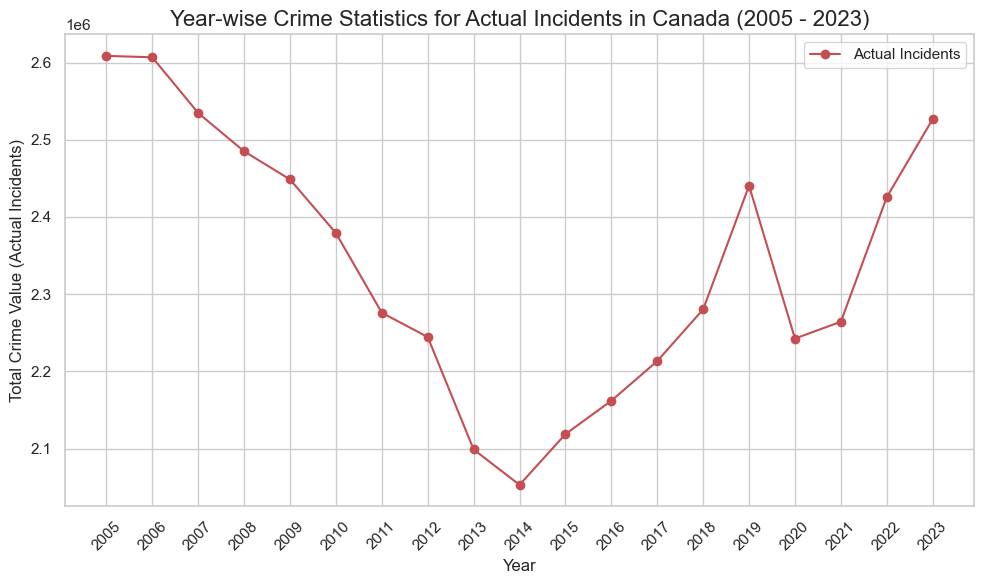

In [94]:
#Showing the trend over year from 2005 to 2023
#Setting plot style
sns.set(style="whitegrid")

#Plotting the crime data for Actual incidents
plt.figure(figsize=(10,6))
plt.plot(NationalLevelActualIncidents['Year'], NationalLevelActualIncidents['VALUE'], marker='o', linestyle='-', color='r', label='Actual Incidents')

#Adding titles and labels
plt.title('Year-wise Crime Statistics for Actual Incidents in Canada (2005 - 2023)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Crime Value (Actual Incidents)', fontsize=12)
plt.xticks(NationalLevelActualIncidents['Year'], rotation=45)
plt.tight_layout()

#Showing the plot
plt.legend()
plt.show()

Distribution of Violations Type in Canada: 
                          Violations Type       VALUE
3         Total property crime violations  24421586.0
4  Total violent Criminal Code violations   8450906.0
2    Total other Criminal Code violations   6808076.0
0  Total Criminal Code traffic violations   2490925.0
1        Total Federal Statute violations   2237786.0


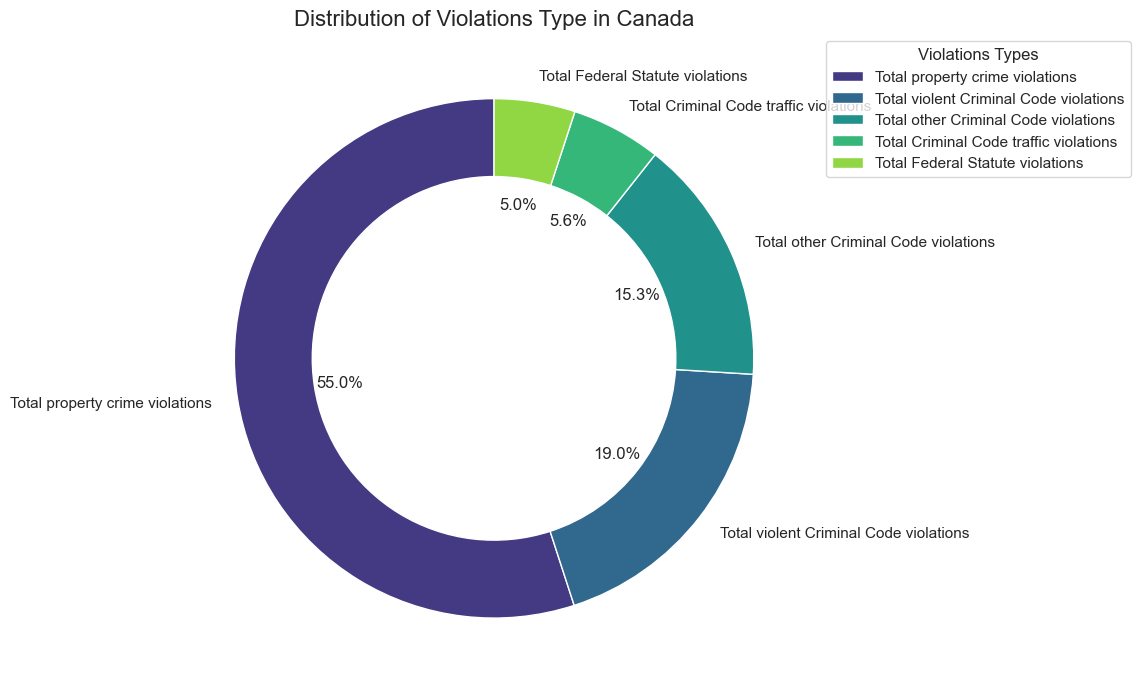

In [95]:
#Getting the distribution of violation type in Canada
NationalLevelTopViolationsType = NationalLevelCrime[NationalLevelCrime['Statistics'] == "Actual incidents"] \
    .groupby('Violations Type')['VALUE'].sum().reset_index()
    
#Displaying the distribution of violation type in Canada
NationalLevelTopViolationsType = NationalLevelTopViolationsType.sort_values(by='VALUE', ascending=False).head(10)
print("Distribution of Violations Type in Canada: ")
print(NationalLevelTopViolationsType)

#Setting plot style
sns.set(style="whitegrid")

#Creating a Donut chart
plt.figure(figsize=(10, 8))

#Plotting the pie chart
plt.pie(NationalLevelTopViolationsType['VALUE'], labels=NationalLevelTopViolationsType['Violations Type'],
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(NationalLevelTopViolationsType)),
        wedgeprops=dict(width=0.3))  # This creates the donut chart by giving the pie a "hole"

#Adding a title
plt.title('Distribution of Violations Type in Canada', fontsize=16)

#Displaying the legend
plt.legend(NationalLevelTopViolationsType['Violations Type'], title="Violations Types", loc='upper left', bbox_to_anchor=(1, 1))

#Showing the plot
plt.tight_layout()
plt.show()

In [96]:
#Grouping the data by 'Violations Type' and 'Main Violations' and summing the 'VALUE'
Top5MainViolations = NationalLevelCrime[NationalLevelCrime['Statistics'] == "Actual incidents"] \
    .groupby(['Violations Type', 'Main Violations'])['VALUE'].sum().reset_index()

#Sorting the values within each 'Violations Type'
Top5MainViolations = Top5MainViolations.sort_values(by=['Violations Type', 'VALUE'], ascending=[True, False])

#Getting the top 10 violations for each Violations Type
Top10ViolationsPerType = Top5MainViolations.groupby('Violations Type').head(5)

#Creating an interactive bar plot with Plotly
fig = px.bar(Top10ViolationsPerType,
             x='VALUE',
             y='Main Violations',
             color='Violations Type',
             orientation='h',
             title='Top 5 Violations Within Each Violations Type in Canada',
             labels={'VALUE': 'Total Crime Value', 'Main Violations': 'Main Violations'},
             color_discrete_sequence=px.colors.qualitative.Vivid)

#Customizing layout for better readability
fig.update_layout(
    xaxis_title='Total Crime Value',
    yaxis_title='Main Violations',
    showlegend=True,
    legend_title="Violations Type",
    plot_bgcolor='white',
    title_x=0.5,
    width=1000, 
    height=800  
)

#Showing the interactive plot
fig.show()


In [97]:
#Grouping data by 'Violations Type', 'Main Violations', and 'Violations' and summing the 'VALUE'
Top5SubViolations = NationalLevelCrime[NationalLevelCrime['Statistics'] == "Actual incidents"] \
    .groupby(['Violations Type', 'Main Violations', 'Violations'])['VALUE'].sum().reset_index()

#Sorting the values within each 'Violations Type'
Top10SubViolations = Top5SubViolations.sort_values(by=['Violations Type', 'VALUE'], ascending=[True, False])

#Selecting the top 5 sub-violations per Violations Type
Top10SubViolations = Top10SubViolations.groupby('Violations Type').head(5)

#Creating a stacked bar chart with Plotly
fig = px.bar(Top10SubViolations,
             x='Violations Type', 
             y='VALUE', 
             color='Violations', 
             title='Distribution of Sub-Violations in Canada',
             labels={'VALUE': 'Total Crime Value', 'Violations Type': 'Violations Type', 'Violations': 'Sub Violations'},
             color_discrete_sequence=px.colors.qualitative.Set3,
             barmode='stack')

# Customizing layout for better readability
fig.update_layout(
    xaxis_title='Violations Type',
    yaxis_title='Total Crime Value',
    showlegend=True,
    title_x=0.5,
    plot_bgcolor='white',
    width=1100, 
    height=1000 
)

# Show the interactive plot
fig.show()


To facilitate further exploration and analysis of crime data, we are exporting the NationalLevelCrime dataframe to a CSV file. This file can then be imported into Power BI or any other data visualization tool to gain deeper insights and create interactive visualizations.

In [98]:
#Saving the NationalLevelCrime dataframe to a CSV file
NationalLevelCrime.to_csv("./NationalLevelCrimeStatistics.csv", index=False)

print("Data saved successfully as NationalLevelCrimeStatistics.csv")

Data saved successfully as NationalLevelCrimeStatistics.csv


### Segmenting into Provincial Level

In [99]:
Crime_Statistics_Copy['GEO'].unique()

array(['Canada', 'Newfoundland and Labrador',
       "St. John's, Newfoundland and Labrador", 'Prince Edward Island',
       'Nova Scotia', 'Halifax, Nova Scotia', 'New Brunswick',
       'Saint John, New Brunswick', 'Quebec', 'Saguenay, Quebec',
       'Québec, Quebec', 'Sherbrooke, Quebec', 'Trois-Rivières, Quebec',
       'Montréal, Quebec', 'Ottawa-Gatineau, Quebec part', 'Ontario',
       'Ottawa-Gatineau, Ontario/Quebec [24505/35505]',
       'Ottawa-Gatineau, Ontario part', 'Kingston, Ontario',
       'Toronto, Ontario', 'Hamilton, Ontario',
       'St. Catharines-Niagara, Ontario',
       'Kitchener-Cambridge-Waterloo, Ontario', 'London, Ontario',
       'Windsor, Ontario', 'Greater Sudbury, Ontario',
       'Thunder Bay, Ontario', 'Manitoba', 'Winnipeg, Manitoba',
       'Saskatchewan', 'Regina, Saskatchewan', 'Saskatoon, Saskatchewan',
       'Alberta', 'Calgary, Alberta', 'Edmonton, Alberta',
       'British Columbia', 'Abbotsford-Mission, British Columbia',
       'Vancouve

In [100]:
#Listing known provinces in Canada
CanadaProvince = [
    'Alberta', 'British Columbia', 'Manitoba', 'New Brunswick', 'Newfoundland and Labrador', 
    'Northwest Territories', 'Nova Scotia', 'Nunavut', 'Ontario', 'Prince Edward Island', 
    'Quebec', 'Saskatchewan', 'Yukon'
]

#Function to extract provinces from the GEO column that starts with a known province name
def match_province(geo_value):
    for province in CanadaProvince:
        if geo_value.startswith(province):  #Checking if the GEO starts with the known province
            
            #Extracting the province
            match = re.match(r'([A-Za-z\s,/-]+)', geo_value)
            if match:
                return match.group(1).strip()  # Clean up any extra spaces
    return None  #If no match is found, return None

#Extracting and cleaning provinces from the GEO column
Crime_Statistics_Copy['Province'] = Crime_Statistics_Copy['GEO'].apply(match_province)

#Filtering out None values (no match found)
ExtractedProvinces = Crime_Statistics_Copy['Province'].dropna().unique()

#Displaying the list of provinces found in the dataset
print("List of provinces in the dataset:")
print(ExtractedProvinces)

List of provinces in the dataset:
['Newfoundland and Labrador' 'Prince Edward Island' 'Nova Scotia'
 'New Brunswick' 'Quebec' 'Ontario' 'Manitoba' 'Saskatchewan' 'Alberta'
 'British Columbia' 'Yukon' 'Northwest Territories' 'Nunavut']


In [101]:
#Filtering the Crime_Statistics dataframe for each province and creating a new dataframe
ProvinceLevelCrime = Crime_Statistics_Copy[Crime_Statistics_Copy['GEO'].isin(ExtractedProvinces)].copy()

#Resetting index for better handling
ProvinceLevelCrime.reset_index(drop=True, inplace=True)

In [102]:
#Loading the first five rows of ProvinceLevelCrime dataset
ProvinceLevelCrime.head(5)

Year                        GEO            Violations                                         Statistics      UOM       VECTOR COORDINATE  VALUE Main Violations                         Violations Type                   Province
0  2005  Newfoundland and Labrador  Murder, first degree                                   Actual incidents   Number    v44344235      2.6.1   8.00        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador
1  2005  Newfoundland and Labrador  Murder, first degree                        Rate per 100,000 population     Rate    v44399253      2.6.2   1.56        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador
2  2005  Newfoundland and Labrador  Murder, first degree  Percentage contribution to the Crime Severity ...  Percent  v1545648286     2.6.17   2.50        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador
3  2005  Newfoundland and Labrador  Murder, first degree                                      Total cleared   Number    v44348469      2.6.4   8.00        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador
4  2005  Newfoundland and Labrador  Murder, first degree                                  Cleared by charge   Number    v44379720      2.6.5   6.00        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador

In [103]:
#Checking the shape of ProvinceLevelCrime dataset
ProvinceLevelCrime.shape

(581928, 11)

Before moving further, let's conduct the analysis to compare the National Level Crime and Province Level Crime values for the years 2005 to 2023.

In [104]:
#List of years from 2005 to 2023
Years = list(range(2005, 2024))

#Initializing an empty list to store results for each year
MatchedResults = []

#Looping through each year and filter both NationalLevelCrime and ProvinceLevelCrime datasets
for year in Years:
    #Filtering the ProvinceLevelCrime dataset for the given year and other conditions
    FilteredProvinceLevel = ProvinceLevelCrime[(ProvinceLevelCrime['Year'] == year) & 
                                               (ProvinceLevelCrime['Statistics'] == "Actual incidents")]
    
    #Grouping and summing 'VALUE' for Province Level
    ProvinceTotalValue = FilteredProvinceLevel.groupby(['Violations Type', 'Main Violations', 'Violations'])['VALUE'].sum().sum()

    #Filtering the NationalLevelCrime dataset for the given year and other conditions
    FilteredNationalLevel = NationalLevelCrime[(NationalLevelCrime['Year'] == year) & 
                                               (NationalLevelCrime['Statistics'] == "Actual incidents")]
    
    #Grouping and summing 'VALUE' for National Level
    NationalTotalValue = FilteredNationalLevel.groupby(['Violations Type', 'Main Violations', 'Violations'])['VALUE'].sum().sum()
    
    #Checking if the summed values match
    Matched = 'Yes' if NationalTotalValue == ProvinceTotalValue else 'No'
    
    #Adding the result for the current year to the list
    MatchedResults.append({'Year': year, 
                           'Total Province Value': ProvinceTotalValue,
                           'Total National Value': NationalTotalValue,
                           'Matched': Matched})

#Converting the matched results to a DataFrame for better readability
MatchedResultsDataframe = pd.DataFrame(MatchedResults)

#Displaying the result of the comparison
print(MatchedResultsDataframe)

    Year  Total Province Value  Total National Value Matched
0   2005             2608741.0             2608741.0     Yes
1   2006             2606887.0             2606887.0     Yes
2   2007             2534730.0             2534730.0     Yes
3   2008             2485043.0             2485043.0     Yes
4   2009             2448654.0             2448654.0     Yes
5   2010             2379130.0             2379130.0     Yes
6   2011             2275917.0             2275917.0     Yes
7   2012             2244458.0             2244458.0     Yes
8   2013             2098776.0             2098776.0     Yes
9   2014             2052925.0             2052925.0     Yes
10  2015             2118681.0             2118681.0     Yes
11  2016             2161927.0             2161927.0     Yes
12  2017             2213293.0             2213293.0     Yes
13  2018             2280328.0             2280328.0     Yes
14  2019             2440496.0             2440496.0     Yes
15  2020             224

The comparison shows that for the majority of the years, the values from both the national and provincial datasets match perfectly. However, there are discrepancies in the values for the years 2020, 2021, 2022, and 2023, where the values for Province Level Crime slightly differ from the National Level Crime values.

The discrepancies observed are likely due to the inclusion of Canadian Forces Military Police (CF MP Gp) data at the national level, which is not reflected at the provincial level. As per the metadata, the Canadian Forces Military Police (CF MP Gp) began reporting incidents to the Uniform Crime Reporting (UCR) Survey from January 2020.

In [105]:
#Filtering only the rows where 'Matched' is 'No'
DiscrepancyData = MatchedResultsDataframe[MatchedResultsDataframe['Matched'] == 'No'].copy()

#Calculating the difference
DiscrepancyData['Difference'] = DiscrepancyData['Total National Value'] - DiscrepancyData['Total Province Value']

#Displaying the results
print(DiscrepancyData[['Year', 'Total Province Value', 'Total National Value', 'Difference']])

    Year  Total Province Value  Total National Value  Difference
15  2020             2241409.0             2242459.0      1050.0
16  2021             2262772.0             2264285.0      1513.0
17  2022             2423742.0             2425672.0      1930.0
18  2023             2524667.0             2526877.0      2210.0


Let's verify the counts for Canadian Forces Military Police [99001] for the years with the discrepancy to see if this is the reason for discrepancies or not.

In [106]:
#Filtering the dataset for Canadian Forces Military Police [99001]
MilitaryPoliceData = Crime_Statistics_Copy[
    (Crime_Statistics_Copy['GEO'] == "Canadian Forces Military Police") & 
    (Crime_Statistics_Copy['Statistics'] == "Actual incidents")
]

#Summing 'VALUE' across all violations for each year
MilitaryPoliceTotal = MilitaryPoliceData.groupby('Year', as_index=False)['VALUE'].sum()

#Displaying the summarized data
print(MilitaryPoliceTotal)


   Year   VALUE
0  2020  1050.0
1  2021  1513.0
2  2022  1930.0
3  2023  2210.0


The discrepancy observed in the National Level Crime and Province Level Crime data for the years 2020, 2021, 2022, and 2023 aligns with the inclusion of crime data reported by the Canadian Forces Military Police (CF MP Gp) at the national level, which is not reflected in the province-level data.

The CF MP Gp data is aggregated at the national level for confidentiality and small count protection, further confirming that the discrepancy is due to the absence of this data in the province-level breakdown.

#### Visualization 1 - Box Plot: Distribution of Crimes by Province

In [107]:
#Filtering data for Violations Type from 2005 to 2023
ProvinceLevelViolationType = ProvinceLevelCrime[
    (ProvinceLevelCrime['Year'].between(2005, 2023)) &
    (ProvinceLevelCrime['Statistics'] == "Actual incidents") &
    (ProvinceLevelCrime['Violations Type'].isin([
        'Total property crime violations', 
        'Total violent Criminal Code violations',
        'Total other Criminal Code violations', 
        'Total Criminal Code traffic violations',
        'Total Federal Statute violations'
    ]))
]  

#Creating the box plot using Plotly
fig = px.box(
    ProvinceLevelViolationType, 
    x="GEO", 
    y="VALUE", 
    title="Distribution of Crime Incidents by Province (2005-2023)", 
    labels={"GEO": "Province", "VALUE": "Crime Incidents"},
    color="GEO"  # Different colors for each province
)

#Rotating x-axis labels for readability
fig.update_layout(xaxis_tickangle=-45)

#Showing the plot
fig.show()

#### Visualization 2 - Line Chart: Crime Trends Over Time (2005-2023)

In [108]:
#Grouping by Year and Province, and summing the crimes for each combination
CrimeTrends = ProvinceLevelViolationType.groupby(['Year', 'Province'], as_index=False)['VALUE'].sum()

#Creating a line chart to visualize crime trends over the years for each province
fig = px.line(CrimeTrends, 
              x="Year", 
              y="VALUE", 
              color="Province",
              title="Crime Trends Across Provinces (2005-2023)",
              labels={"VALUE": "Total Crimes", "Year": "Year", "Province": "Province"})

fig.show()

#### Visualization 3 - Pie Chart: Crime Distribution Across Provinces

In [109]:
#Pie chart for crime distribution across provinces
fig = px.pie(ProvinceLevelViolationType, 
             names="Province", 
             values="VALUE", 
             title="Crime Distribution Across Canadian Provinces (2005-2023)")

fig.show()

In [110]:
#Saving the ProvinceLevelCrime dataframe to a CSV file
ProvinceLevelCrime.to_csv("./ProvinceLevelCrimeStatistics.csv", index=False)

print("Data saved successfully as ProvinceLevelCrimeStatistics.csv")

Data saved successfully as ProvinceLevelCrimeStatistics.csv


### Segmenting into City Level

In [111]:
#Function to extract city and province
def extract_city_province(geo_value):
    
    #Excluding "Canada" and provinces listed without a city
    ExcludedGEO = ['Canada', 'Newfoundland and Labrador', 'Prince Edward Island', 
                          'Nova Scotia', 'New Brunswick', 'Quebec', 'Ontario', 
                          'Manitoba', 'Saskatchewan', 'Alberta', 'British Columbia', 
                          'Yukon', 'Northwest Territories', 'Nunavut']

    #If geo_value is just a province or 'Canada', return None for both city and province
    if geo_value in ExcludedGEO:
        return None, None

    #Special case handling for "Ottawa-Gatineau" with province info
    if "Ottawa-Gatineau" in geo_value:
        #Handle Ottawa-Gatineau cases by splitting the provinces from the part
        if 'Quebec' in geo_value:
            province = 'Quebec'
        elif 'Ontario' in geo_value:
            province = 'Ontario'
        else:
            province = geo_value.split(",")[-1].strip()
        city = "Ottawa-Gatineau"
        return city, province

    #For other cases with a comma, split into city and province
    if ',' in geo_value:
        city, province = geo_value.split(',', 1)
        city = city.strip()  # Remove leading/trailing spaces
        province = province.strip()  # Remove leading/trailing spaces
        return city, province
    else:
        #In case no comma is found, return None
        return None, None

#Applying the function to extract city and province
Crime_Statistics_Copy[['City', 'Province']] = Crime_Statistics_Copy['GEO'].apply(
    lambda x: pd.Series(extract_city_province(x))
)

#Dropping rows where both city and province are None
CityLevelCrime = Crime_Statistics_Copy.dropna(subset=['City', 'Province'], how='all')

#Resetting index for better handling
CityLevelCrime.reset_index(drop=True, inplace=True)

In [112]:
#Display the filtered dataset
CityLevelCrime.head(5)

Year                                    GEO            Violations                                         Statistics      UOM       VECTOR COORDINATE  VALUE Main Violations                         Violations Type                   Province        City
0  2005  St. John's, Newfoundland and Labrador  Murder, first degree                                   Actual incidents   Number    v44353366      3.6.1   1.00        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador  St. John's
1  2005  St. John's, Newfoundland and Labrador  Murder, first degree                        Rate per 100,000 population     Rate    v44330037      3.6.2   0.55        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador  St. John's
2  2005  St. John's, Newfoundland and Labrador  Murder, first degree  Percentage contribution to the Crime Severity ...  Percent  v1545651707     3.6.17   0.72        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador  St. John's
3  2005  St. John's, Newfoundland and Labrador  Murder, first degree                                      Total cleared   Number    v44366265      3.6.4   1.00        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador  St. John's
4  2005  St. John's, Newfoundland and Labrador  Murder, first degree                                  Cleared by charge   Number    v44383061      3.6.5   0.00        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador  St. John's

In [113]:
#Checking the unique Citites in CityLevelCrime dataset
CityLevelCrime['City'].unique()

array(["St. John's", 'Halifax', 'Saint John', 'Saguenay', 'Québec',
       'Sherbrooke', 'Trois-Rivières', 'Montréal', 'Ottawa-Gatineau',
       'Kingston', 'Toronto', 'Hamilton', 'St. Catharines-Niagara',
       'Kitchener-Cambridge-Waterloo', 'London', 'Windsor',
       'Greater Sudbury', 'Thunder Bay', 'Winnipeg', 'Regina',
       'Saskatoon', 'Calgary', 'Edmonton', 'Abbotsford-Mission',
       'Vancouver', 'Victoria', 'Moncton', 'Peterborough', 'Brantford',
       'Guelph', 'Barrie', 'Kelowna', 'Belleville-Quinte West',
       'Lethbridge', 'Fredericton', 'Drummondville', 'Red Deer',
       'Kamloops', 'Chilliwack', 'Nanaimo'], dtype=object)

In [114]:
#Checking the unique Provinces in CityLevelCrime dataset
CityLevelCrime['Province'].unique()

array(['Newfoundland and Labrador', 'Nova Scotia', 'New Brunswick',
       'Quebec', 'Ontario', 'Manitoba', 'Saskatchewan', 'Alberta',
       'British Columbia'], dtype=object)

In [115]:
CityLevelCrime.shape

(1596822, 12)

Before moving further, let's conduct the analysis to compare the Province Level Crime and City Level Crime values for the years 2005 to 2023 for Ontario.

In [116]:
#Filtering province-level data
ProvinceLevelIncidents = ProvinceLevelCrime[
    (ProvinceLevelCrime['Year'].between(2005, 2023)) &
    (ProvinceLevelCrime['Statistics'] == "Actual incidents") &
    (ProvinceLevelCrime['Province'] == "Ontario") &
    (ProvinceLevelCrime['Violations Type'].isin([
        'Total property crime violations', 
        'Total violent Criminal Code violations',
        'Total other Criminal Code violations', 
        'Total Criminal Code traffic violations',
        'Total Federal Statute violations'
    ]))
]

#Selecting relevant columns with the correct column name
ProvinceLevelIncidents = ProvinceLevelIncidents[['Province', 'Year', 'VALUE']]

#Grouping Province-level data by Province and Year
ProvinceAggregated = ProvinceLevelIncidents.groupby(['Province', 'Year'], as_index=False)['VALUE'].sum()

print(ProvinceAggregated)

   Province  Year     VALUE
0   Ontario  2005  729941.0
1   Ontario  2006  756006.0
2   Ontario  2007  726995.0
3   Ontario  2008  705715.0
4   Ontario  2009  690180.0
5   Ontario  2010  666393.0
6   Ontario  2011  636172.0
7   Ontario  2012  618486.0
8   Ontario  2013  566931.0
9   Ontario  2014  547570.0
10  Ontario  2015  551243.0
11  Ontario  2016  567627.0
12  Ontario  2017  599314.0
13  Ontario  2018  645201.0
14  Ontario  2019  660927.0
15  Ontario  2020  595546.0
16  Ontario  2021  620881.0
17  Ontario  2022  672285.0
18  Ontario  2023  737246.0


In [117]:
#Filtering city-level data
CityLevelIncidents = CityLevelCrime[
    (CityLevelCrime['Year'].between(2005, 2023)) &
    (CityLevelCrime['Statistics'] == "Actual incidents") &
    (CityLevelCrime['Province'] == "Ontario") &
    (CityLevelCrime['Violations Type'].isin([
        'Total property crime violations', 
        'Total violent Criminal Code violations',
        'Total other Criminal Code violations', 
        'Total Criminal Code traffic violations',
        'Total Federal Statute violations'
    ]))
]

#Selecting relevant columns
CityLevelIncidents = CityLevelIncidents[['Province', 'Year', 'VALUE']]

#Grouping City-level data by Province and Year
CityAggregated = CityLevelIncidents.groupby(['Province', 'Year'], as_index=False)['VALUE'].sum()

print(CityAggregated)

   Province  Year     VALUE
0   Ontario  2005  499846.0
1   Ontario  2006  556194.0
2   Ontario  2007  533069.0
3   Ontario  2008  514660.0
4   Ontario  2009  504551.0
5   Ontario  2010  484493.0
6   Ontario  2011  464842.0
7   Ontario  2012  449144.0
8   Ontario  2013  415842.0
9   Ontario  2014  405012.0
10  Ontario  2015  408854.0
11  Ontario  2016  428961.0
12  Ontario  2017  455327.0
13  Ontario  2018  491031.0
14  Ontario  2019  499644.0
15  Ontario  2020  443227.0
16  Ontario  2021  465218.0
17  Ontario  2022  515409.0
18  Ontario  2023  574203.0


Looks like city-level data is not complete. The sum of all city-level crime incidents does not match the total sum at the province level. This discrepancy suggests that either the data provided for cities is incomplete or certain data has not been disclosed.  

Despite this limitation, we will proceed with our analysis using the available datasets.

In [118]:
#Grouping by City and Province and sum the 'VALUE' column for crime incidents
CityData = CityLevelCrime.groupby(['City', 'Province'], as_index=False)['VALUE'].sum()

#Sorting the data to get the top 10 cities with the highest crime incidents across all provinces
Top10Cities = CityData.sort_values(by='VALUE', ascending=False).head(10)

#Creating a bar chart using Plotly
fig = px.bar(Top10Cities, 
             x='City', 
             y='VALUE', 
             color='Province', 
             title='Top 10 Cities with Most Crime Incidents Across All Provinces',
             labels={'VALUE': 'Crime Incidents', 'City': 'City Name'},
             color_discrete_sequence=px.colors.qualitative.Set2)

#Showing the plot
fig.show()

In [119]:
#Sorting the data to get the top 10 cities with the highest crime incidents across all provinces
Lowest10Cities = CityData.sort_values(by='VALUE', ascending=True).head(10)

#Creating a bar chart using Plotly
fig = px.bar(Lowest10Cities, 
             x='City', 
             y='VALUE', 
             color='Province', 
             title='Top 10 Cities with Lowest Crime Incidents Across All Provinces',
             labels={'VALUE': 'Crime Incidents', 'City': 'City Name'},
             color_discrete_sequence=px.colors.qualitative.Set2)

#Showing the plot
fig.show()

In [120]:
#Saving the CityLevelCrime dataframe to a CSV file
CityLevelCrime.to_csv("./CityLevelCrimeStatistics.csv", index=False)

print("Data saved successfully as CityLevelCrimeStatistics.csv")

Data saved successfully as CityLevelCrimeStatistics.csv


## 13. Predictive Analysis

### National Level

In [121]:
#Loading the dataset
NationalLevelCrime.head(10)

Year     GEO            Violations                                         Statistics      UOM       VECTOR COORDINATE   VALUE Main Violations                         Violations Type
1875406  2005  Canada  Murder, first degree                                   Actual incidents   Number    v44391126      1.6.1  313.00        Homicide  Total violent Criminal Code violations
1875407  2005  Canada  Murder, first degree                        Rate per 100,000 population     Rate    v44347387      1.6.2    0.97        Homicide  Total violent Criminal Code violations
1875408  2005  Canada  Murder, first degree                          Percentage change in rate  Percent    v44332852      1.6.3   -6.05        Homicide  Total violent Criminal Code violations
1875409  2005  Canada  Murder, first degree  Percentage contribution to the Crime Severity ...  Percent  v1545644865     1.6.17    1.21        Homicide  Total violent Criminal Code violations
1875412  2005  Canada  Murder, first degree                                      Total cleared   Number    v44388137      1.6.4  191.00        Homicide  Total violent Criminal Code violations
1875413  2005  Canada  Murder, first degree                                  Cleared by charge   Number    v44345706      1.6.5  152.00        Homicide  Total violent Criminal Code violations
1875414  2005  Canada  Murder, first degree                                  Cleared otherwise   Number    v44410846      1.6.6   39.00        Homicide  Total violent Criminal Code violations
1875415  2005  Canada  Murder, first degree                             Total, persons charged   Number    v44343383      1.6.7  230.00        Homicide  Total violent Criminal Code violations
1875416  2005  Canada  Murder, first degree  Rate, total persons charged per 100,000 popula...     Rate    v44393963      1.6.8    0.83        Homicide  Total violent Criminal Code violations
1875417  2005  Canada  Murder, first degree                               Total, adult charged   Number    v44376857      1.6.9  208.00        Homicide  Total violent Criminal Code violations

In [122]:
#Verifying the data types for each columns
NationalLevelCrime.dtypes

Year                 int64
GEO                 object
Violations          object
Statistics          object
UOM                 object
VECTOR              object
COORDINATE          object
VALUE              float64
Main Violations     object
Violations Type     object
dtype: object

In [123]:
#Dropping unnecessary columns
ColumnsToDrop = ["VECTOR", "COORDINATE"]
NationalLevelCrime.drop(columns=ColumnsToDrop, inplace=True, errors='ignore')

In [124]:
#Making a copy of NationalCrimeData
YearlyCrimeCount = NationalLevelCrime.copy()

#Filtering the dataset for rows where 'Statistics' column is 'Actual Incidents'
YearlyCrimeCount = YearlyCrimeCount[YearlyCrimeCount['Statistics'] == 'Actual incidents']

#Aggregating data to get crime counts per year
TotalYearlyCrimeCount = YearlyCrimeCount.groupby('Year', as_index=False)['VALUE'].sum()
TotalYearlyCrimeCount = TotalYearlyCrimeCount[['Year', 'VALUE']]

print(TotalYearlyCrimeCount)

    Year      VALUE
0   2005  2608741.0
1   2006  2606887.0
2   2007  2534730.0
3   2008  2485043.0
4   2009  2448654.0
5   2010  2379130.0
6   2011  2275917.0
7   2012  2244458.0
8   2013  2098776.0
9   2014  2052925.0
10  2015  2118681.0
11  2016  2161927.0
12  2017  2213293.0
13  2018  2280328.0
14  2019  2440496.0
15  2020  2242459.0
16  2021  2264285.0
17  2022  2425672.0
18  2023  2526877.0


In [125]:
#Renaming columns to be compatible with Prophet
ProphetNationalCrimeData = TotalYearlyCrimeCount.rename(columns={'Year': 'ds', 'VALUE': 'y'})

#Converting 'ds' (Year) to datetime, even though it's just the year
ProphetNationalCrimeData['ds'] = pd.to_datetime(ProphetNationalCrimeData['ds'], format='%Y')

In [126]:
#Initializing and fit the Prophet model
NationalModel1 = Prophet()
NationalModel1.fit(ProphetNationalCrimeData)

22:33:55 - cmdstanpy - INFO - Chain [1] start processing
22:33:55 - cmdstanpy - INFO - Chain [1] done processing


In [127]:
#Creating a future dataframe for the next 5 years using 'YE'
NationalFuture1 = NationalModel1.make_future_dataframe(periods=7, freq='YS')

In [128]:
#Making predictions
NationalForecast1 = NationalModel1.predict(NationalFuture1)

In [129]:
#Preparing data using cleaned forecast
NationalForecast1['year'] = NationalForecast1['ds'].dt.year
CleanForecast = NationalForecast1[['year', 'yhat', 'yhat_lower', 'yhat_upper']].drop_duplicates('year')

#Creating interactive plot
fig = go.Figure()

#Adding historical data
fig.add_trace(go.Scatter(
    x=CleanForecast['year'][:-8],
    y=CleanForecast['yhat'][:-8],
    mode='lines+markers',
    name='Historical',
    line=dict(color='blue', width=2),
    marker=dict(size=8)
))

#Adding forecast
fig.add_trace(go.Scatter(
    x=CleanForecast['year'][-8:],
    y=CleanForecast['yhat'][-8:],
    mode='lines+markers',
    name='Forecast',
    line=dict(color='red', width=2, dash='dot'),
    marker=dict(size=8, symbol='star')
))

#Adding confidence interval
fig.add_trace(go.Scatter(
    x=CleanForecast['year'][-8:].tolist() + CleanForecast['year'][-8:].tolist()[::-1],
    y=CleanForecast['yhat_upper'][-8:].tolist() + CleanForecast['yhat_lower'][-8:].tolist()[::-1],
    fill='toself',
    fillcolor='rgba(255,0,0,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Confidence Interval'
))

#Customizing layout
fig.update_layout(
    title='Crime Rate Forecast (2024-2030)',
    xaxis_title='Year',
    yaxis_title='Predicted Crime Count',
    hovermode='x unified',
    template='plotly_white',
    height=600,
    annotations=[
        dict(
            x=0.05, y=0.95,
            xref='paper', yref='paper',
            text=f'Last Historical Year: {CleanForecast["year"].iloc[-8]}',
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

#Adding forecast period annotation
for year, y in zip(CleanForecast['year'][-8:], CleanForecast['yhat'][-8:]):
    fig.add_annotation(
        x=year, y=y,
        text=f"{y/1e6:.1f}M",
        showarrow=True,
        arrowhead=1,
        ax=0, ay=-40
    )

fig.show()

In [130]:
#Saving the future forecast into csv file
NationalForecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('CanadaCrimeForecast7year.csv', index=False)

In [131]:
#Creating a copy of NationalLevelCrime
ViolationTypeCrime = NationalLevelCrime.copy()

#Filtering the dataset for rows where 'Statistics' column is 'Actual Incidents'
ViolationTypeCrime = ViolationTypeCrime[ViolationTypeCrime['Statistics'] == 'Actual incidents']

#Preparing the data
ViolationTypeCrime = ViolationTypeCrime.groupby(['Year', 'Violations Type'])['VALUE'].sum().unstack()

#Creating Prophet-compatible DataFrames
ProphetViolationsType = {}
for col in ViolationTypeCrime.columns:
    ProphetViolationsType[col] = ViolationTypeCrime[col].reset_index() \
        .rename(columns={'Year': 'ds', col: 'y'})
    ProphetViolationsType[col]['ds'] = pd.to_datetime(ProphetViolationsType[col]['ds'], format='%Y')

#Previewing the data
print("Crime Counts by Violation Type:")
print(ViolationTypeCrime.head())

#Training models and forecast
NationalForecast2 = {}
for name, df in ProphetViolationsType.items():
    print(f"\nTraining model for: {name}")
    NationalModel2 = Prophet(yearly_seasonality=True)
    NationalModel2.fit(df)
    
    NationalFuture2 = NationalModel2.make_future_dataframe(periods=7, freq='YS')
    NationalForecast2[name] = NationalModel2.predict(NationalFuture2)
    
    #Printing last 5 forecasted values
    print(NationalForecast2[name][['ds', 'yhat']].tail())

Crime Counts by Violation Type:
Violations Type  Total Criminal Code traffic violations  Total Federal Statute violations  Total other Criminal Code violations  Total property crime violations  Total violent Criminal Code violations
Year                                                                                                                                                                                                    
2005                                           121936.0                          124831.0                              339309.0                        1574808.0                                447857.0
2006                                           122439.0                          124644.0                              341837.0                        1566315.0                                451652.0
2007                                           132278.0                          130698.0                              338399.0                        1488103.0    

22:33:55 - cmdstanpy - INFO - Chain [1] start processing
22:33:55 - cmdstanpy - INFO - Chain [1] done processing
22:33:55 - cmdstanpy - INFO - Chain [1] start processing
22:33:55 - cmdstanpy - INFO - Chain [1] done processing
22:33:55 - cmdstanpy - INFO - Chain [1] start processing
22:33:56 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat
21 2026-01-01  120662.160729
22 2027-01-01  122067.141624
23 2028-01-01  123750.477980
24 2029-01-01  116409.021528
25 2030-01-01  117532.779611

Training model for: Total Federal Statute violations
           ds          yhat
21 2026-01-01  75725.134619
22 2027-01-01  73830.534748
23 2028-01-01  72231.157182
24 2029-01-01  64162.553184
25 2030-01-01  61970.956578

Training model for: Total other Criminal Code violations


22:33:56 - cmdstanpy - INFO - Chain [1] start processing


           ds           yhat
21 2026-01-01  421885.789181
22 2027-01-01  429566.390087
23 2028-01-01  435696.310663
24 2029-01-01  438331.959334
25 2030-01-01  447560.304161

Training model for: Total property crime violations


22:33:56 - cmdstanpy - INFO - Chain [1] done processing
22:33:56 - cmdstanpy - INFO - Chain [1] start processing
22:33:56 - cmdstanpy - INFO - Chain [1] done processing


           ds          yhat
21 2026-01-01  1.117094e+06
22 2027-01-01  1.096382e+06
23 2028-01-01  1.060976e+06
24 2029-01-01  1.063916e+06
25 2030-01-01  1.057906e+06

Training model for: Total violent Criminal Code violations
           ds           yhat
21 2026-01-01  499577.763150
22 2027-01-01  502546.241498
23 2028-01-01  502520.226444
24 2029-01-01  511264.306919
25 2030-01-01  517228.686849


In [132]:
#Combining forecasts
AllNationalForecast2 = pd.concat([
    fcst.assign(Violation_Type=name) 
    for name, fcst in NationalForecast2.items()
])

#Interactive plot
px.line(AllNationalForecast2, x='ds', y='yhat', color='Violation_Type',
       title='5-Year Crime Forecast by Violation Type')

In [133]:
#Preparing the violations type forecast data for export
CanadaViolationTypeForecast7year = pd.concat([
    NationalForecast2[name][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].assign(Violation_Type=name)
    for name in NationalForecast2
])

#Adding readable year column
CanadaViolationTypeForecast7year['Year'] = CanadaViolationTypeForecast7year['ds'].dt.year

#Adding historical/forecast flag
CanadaViolationTypeForecast7year['Period'] = np.where(
    CanadaViolationTypeForecast7year['Year'] <= 2023, 
    'Historical', 
    'Forecast'
)

#Saving to CSV
CanadaViolationTypeForecast7year.to_csv('CanadaViolationTypeForecast7year.csv', index=False)

In [134]:
#Preparing violations type trends
CanadaViolationTypeForecast7yearTrend = pd.concat([
    NationalForecast2[name][['ds', 'trend']].assign(Violation_Type=name)
    for name in NationalForecast2
])
CanadaViolationTypeForecast7yearTrend.to_csv('CanadaViolationTypeForecast7yearTrend.csv', index=False)

In [135]:
#Creating a copy of NationalLevelCrime
MainViolations = NationalLevelCrime.copy()

#Filtering the dataset for rows where 'Statistics' column is 'Actual Incidents'
MainViolations = MainViolations[MainViolations['Statistics'] == 'Actual incidents']

#Grouping by Year and Main Violation
MainViolations = MainViolations.groupby(['Year', 'Main Violations'])['VALUE'].sum().unstack()

#Train models for EVERY violation
NationalForecast3 = {}
for violation in MainViolations.columns:
    df = MainViolations[violation].reset_index()\
         .rename(columns={'Year': 'ds', violation: 'y'})
    df['ds'] = pd.to_datetime(df['ds'], format='%Y')
    
    NationalModel3 = Prophet(yearly_seasonality=True)
    NationalModel3.fit(df)
    
    NationalFuture3 = NationalModel3.make_future_dataframe(periods=7, freq='YS')
    NationalForecast3[violation] = NationalModel3.predict(NationalFuture3)

22:33:56 - cmdstanpy - INFO - Chain [1] start processing


22:33:56 - cmdstanpy - INFO - Chain [1] done processing
22:33:56 - cmdstanpy - INFO - Chain [1] start processing
22:33:56 - cmdstanpy - INFO - Chain [1] done processing
22:33:56 - cmdstanpy - INFO - Chain [1] start processing
22:33:56 - cmdstanpy - INFO - Chain [1] done processing
22:33:56 - cmdstanpy - INFO - Chain [1] start processing
22:33:56 - cmdstanpy - INFO - Chain [1] done processing
22:33:56 - cmdstanpy - INFO - Chain [1] start processing
22:33:56 - cmdstanpy - INFO - Chain [1] done processing
22:33:56 - cmdstanpy - INFO - Chain [1] start processing
22:33:56 - cmdstanpy - INFO - Chain [1] done processing
22:33:56 - cmdstanpy - INFO - Chain [1] start processing
22:33:56 - cmdstanpy - INFO - Chain [1] done processing
22:33:56 - cmdstanpy - INFO - Chain [1] start processing
22:33:56 - cmdstanpy - INFO - Chain [1] done processing
22:33:56 - cmdstanpy - INFO - Chain [1] start processing
22:33:56 - cmdstanpy - INFO - Chain [1] done processing
22:33:56 - cmdstanpy - INFO - Chain [1] 

In [136]:
#Getting 2030 predictions for all violations
MainViolationsPrediction2030 = pd.DataFrame({
    'Violation': [v for v in NationalForecast3.keys()],
    'Projected_2030': [NationalForecast3[v]['yhat'].iloc[-1] for v in NationalForecast3.keys()]
})

#Filtering top 10 violations
Top10MainViolations = MainViolationsPrediction2030.nlargest(10, 'Projected_2030')

In [137]:
#Top 10 Main Violations Projected for 2030
fig = px.bar(
    Top10MainViolations.sort_values('Projected_2030', ascending=True),
    x='Projected_2030',
    y='Violation',
    orientation='h',
    title='Top 10 Main Violations Projected for 2030',
    labels={'Projected_2030': 'Predicted Crime Count'}
)
fig.show()

In [138]:
#Combining ALL forecasts with confidence intervals
CanadaMainViolationsForecast7year = pd.concat([
    NationalForecast3[v][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    .assign(Violation=v)
    for v in NationalForecast3.keys()
])

#Adding metadata
CanadaMainViolationsForecast7year = CanadaMainViolationsForecast7year.assign(
    Year=lambda x: x['ds'].dt.year,
    Period=lambda x: np.where(x['Year'] <= 2023, 'Historical', 'Forecast')
)

#Getting list of top 10 violation names
Top10MainViolationsFuture = Top10MainViolations['Violation'].tolist()

#Filtering for top 10 violations data
Top10MainViolationsFutureData = CanadaMainViolationsForecast7year[
    CanadaMainViolationsForecast7year['Violation'].isin(Top10MainViolationsFuture)
]

# 5. Create visualization
fig = make_subplots(rows=2, cols=1, 
                   subplot_titles=['Historical Trends (2005-2023)', '2030 Projections'])

# Plot historical data
for violation in Top10MainViolationsFuture:
    hist_data = Top10MainViolationsFutureData[
        (Top10MainViolationsFutureData['Violation'] == violation) & 
        (Top10MainViolationsFutureData['Period'] == 'Historical')
    ]
    fig.add_trace(
        go.Scatter(
            x=hist_data['ds'],
            y=hist_data['yhat'],
            mode='lines+markers',
            name=violation,
            legendgroup=violation
        ),
        row=1, col=1
    )

# Plot 2030 projections
for violation in Top10MainViolationsFuture:
    forecast_data = Top10MainViolationsFutureData[
        (Top10MainViolationsFutureData['Violation'] == violation) & 
        (Top10MainViolationsFutureData['Year'] == 2030)
    ]
    fig.add_trace(
        go.Bar(
            x=[violation],
            y=forecast_data['yhat'],
            name=violation,
            error_y=dict(
                type='data',
                array=forecast_data['yhat_upper'] - forecast_data['yhat'],
                arrayminus=forecast_data['yhat'] - forecast_data['yhat_lower']
            ),
            legendgroup=violation,
            showlegend=False
        ),
        row=2, col=1
    )

# Update layout
fig.update_layout(
    title_text='Top 10 Main Violations: History vs 2030 Forecast',
    height=800,
    hovermode='x unified'
)
fig.update_xaxes(rangeslider_visible=True, row=1, col=1)
fig.show()

In [139]:
#Save dataset in CSV file
CanadaMainViolationsForecast7year.to_csv('CanadaMainViolationsForecast7year.csv', index=False)

In [140]:
#Creating a copy of NationalLevelCrime
SubViolations = NationalLevelCrime.copy()

#Filtering the dataset for rows where 'Statistics' column is 'Actual Incidents'
SubViolations = SubViolations[SubViolations['Statistics'] == 'Actual incidents']

#Grouping by Year and Main Violation
SubViolations = SubViolations.groupby(['Year', 'Violations'])['VALUE'].sum().unstack()

NationalForecast4 = {}
for violation in tqdm(SubViolations.columns, desc="Training models"):
    df = SubViolations[violation].reset_index()\
         .rename(columns={'Year': 'ds', violation: 'y'})
    df['ds'] = pd.to_datetime(df['ds'], format='%Y')
    
    NationalModel4 = Prophet(
        yearly_seasonality=True,
        changepoint_prior_scale=0.2  # More flexible trends
    )
    NationalModel4.fit(df)
    
    NationalFuture4 = NationalModel4.make_future_dataframe(periods=7, freq='YS')  # Through 2030
    NationalForecast4[violation] = NationalModel4.predict(NationalFuture4)

Training models:   0%|          | 0/198 [00:00<?, ?it/s]22:34:02 - cmdstanpy - INFO - Chain [1] start processing
22:34:02 - cmdstanpy - INFO - Chain [1] done processing
22:34:02 - cmdstanpy - INFO - Chain [1] start processing
22:34:02 - cmdstanpy - INFO - Chain [1] done processing
Training models:   1%|          | 2/198 [00:00<00:16, 11.69it/s]22:34:02 - cmdstanpy - INFO - Chain [1] start processing
22:34:02 - cmdstanpy - INFO - Chain [1] done processing
22:34:02 - cmdstanpy - INFO - Chain [1] start processing
22:34:02 - cmdstanpy - INFO - Chain [1] done processing
Training models:   2%|▏         | 4/198 [00:00<00:16, 11.74it/s]22:34:02 - cmdstanpy - INFO - Chain [1] start processing
22:34:02 - cmdstanpy - INFO - Chain [1] done processing
22:34:02 - cmdstanpy - INFO - Chain [1] start processing
22:34:02 - cmdstanpy - INFO - Chain [1] done processing
Training models:   3%|▎         | 6/198 [00:00<00:13, 14.25it/s]22:34:02 - cmdstanpy - INFO - Chain [1] start processing
22:34:02 - cmdsta

In [141]:
#Getting 2030 predictions with safe growth calculation
TopSubViolations2030 = pd.DataFrame({
    'Violation': NationalForecast4.keys(),
    'Projected_2030': [fcst['yhat'].iloc[-1] for fcst in NationalForecast4.values()],
    'Growth_2019_2030': [
        #Handleing cases where 2019 count was zero
        (fcst['yhat'].iloc[-1] - fcst_2019) / (fcst_2019 if fcst_2019 != 0 else 1)
        for fcst in NationalForecast4.values()
        for fcst_2019 in [fcst['yhat'].loc[fcst['ds'].dt.year == 2019].values[0]]]
})

#Filtering out infinite growth (from zero baselines)
TopSubViolations2030.replace([np.inf, -np.inf], np.nan, inplace=True)

#Getting top 10 sub-violations
TopSubViolations2030Prediction = (
    TopSubViolations2030
    .dropna(subset=['Growth_2019_2030'])
    .nlargest(10, 'Projected_2030')
)

print("Top 10 Sub-Violations for 2030:")
print(TopSubViolations2030Prediction)

Top 10 Sub-Violations for 2030:
                                   Violation  Projected_2030  Growth_2019_2030
100                                 Mischief   413770.347666          0.475600
8                           Assault, level 1   247536.524503          0.375416
71                                     Fraud   224777.056947          0.686931
176                    Theft $5,000 or under   217788.364011          0.032984
174              Shoplifting $5,000 or under   150736.731683          0.289919
186             Total theft of motor vehicle   146976.129539          0.710376
52                 Fail to comply with order   145880.457986          0.107409
9    Assault, level 2, weapon or bodily harm   127576.483117          1.148443
194                         Uttering threats   125755.451919          0.635742
47                         Disturb the peace   124290.130075          0.209873


In [142]:
#Adding absolute change
TopSubViolations2030Prediction['Absolute_Change'] = (
    TopSubViolations2030Prediction['Projected_2030'] - 
    TopSubViolations2030Prediction['Projected_2030'] / 
    (1 + TopSubViolations2030Prediction['Growth_2019_2030'])
)

In [143]:
fig = px.bar(
    TopSubViolations2030Prediction.sort_values('Projected_2030'),
    x='Projected_2030',
    y='Violation',
    color='Growth_2019_2030',
    orientation='h',
    title='Top 10 Sub-Violations for 2030 (Projected Volume vs Growth)',
    labels={'Projected_2030': 'Predicted Incidents', 'Growth_2019_2030': '% Growth 2019→2030'}
)
fig.update_layout(
    coloraxis_colorbar=dict(title='% Growth'),
    yaxis_categoryorder='total ascending'
)
fig.show()

In [144]:
#Combining ALL sub-violation forecasts
CanadaSubViolationsForecast = pd.concat([
    NationalForecast4[v][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    .assign(SubViolation=v)
    for v in NationalForecast4.keys()
])

#Adding metadata
CanadaSubViolationsForecast = CanadaSubViolationsForecast.assign(
    Year=lambda x: x['ds'].dt.year,
    Period=lambda x: np.where(x['Year'] <= 2023, 'Historical', 'Forecast')
)

#Getting top 10 sub-violation names from your earlier prediction
Top10SubViolationsFuture = TopSubViolations2030Prediction['Violation'].tolist()

# Filter for top 10 sub-violations
Top10SubViolationsFutureData = CanadaSubViolationsForecast[
    CanadaSubViolationsForecast['SubViolation'].isin(Top10SubViolationsFuture)
]

In [145]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=[
        '<b>Historical Trends (2005-2023)</b>', 
        '<b>2030 Projections with Confidence Intervals</b>'
    ],
    vertical_spacing=0.25,
    row_heights=[0.6, 0.4]
)

#Plotting historical trends
for violation in Top10SubViolationsFuture:
    hist_data = Top10SubViolationsFutureData[
        (Top10SubViolationsFutureData['SubViolation'] == violation) & 
        (Top10SubViolationsFutureData['Period'] == 'Historical')
    ]
    fig.add_trace(
        go.Scatter(
            x=hist_data['ds'],
            y=hist_data['yhat'],
            mode='lines+markers',
            name=violation,
            line=dict(width=1)
        ),
        row=1, col=1
    )

#Plotting 2030 projections with error bars
for violation in Top10SubViolationsFuture:
    forecast_data = Top10SubViolationsFutureData[
        (Top10SubViolationsFutureData['SubViolation'] == violation) & 
        (Top10SubViolationsFutureData['Year'] == 2030)
    ]
    fig.add_trace(
        go.Bar(
            x=[violation],
            y=forecast_data['yhat'],
            error_y=dict(
                type='data',
                array=forecast_data['yhat_upper'] - forecast_data['yhat'],
                arrayminus=forecast_data['yhat'] - forecast_data['yhat_lower'],
                thickness=2,
                width=5
            ),
            name=violation,
            showlegend=False,
            width=0.6
        ),
        row=2, col=1
    )

#Updating layout
fig.update_layout(
    title_text='<b>Top 10 Sub-Violations Forecast (2024-2030)</b>',
    title_x=0.5,
    height=900,
    margin=dict(t=50, b=50, l=50, r=50),
    plot_bgcolor='white',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=0.37,
        xanchor="center",
        x=0.5
    )
)

#Formatting axes 
fig.update_xaxes(
    title_text='<b>Sub-Violation</b>',
    row=2, col=1,
    tickangle=45,
    tickfont=dict(size=10)
)

fig.update_yaxes(
    title_text='<b>Incident Count</b>',
    row=1, col=1,
    tickformat=','
)

fig.update_yaxes(
    title_text='<b>2030 Projection</b>',
    row=2, col=1,
    tickformat=','
)

#Adding source note
fig.add_annotation(
    text="Source: Canadian Crime Statistics",
    xref="paper", yref="paper",
    x=0.5, y=-0.2,
    showarrow=False,
    font=dict(size=10)
)

fig.show()

In [146]:
#Save dataset in CSV file
CanadaSubViolationsForecast.to_csv('CanadaSubViolationsForecast7year.csv', index=False)

### Province Level

In [147]:
#Loading the first 10 data
ProvinceLevelCrime.head(10)

Year                        GEO            Violations                                         Statistics      UOM       VECTOR COORDINATE  VALUE Main Violations                         Violations Type                   Province
0  2005  Newfoundland and Labrador  Murder, first degree                                   Actual incidents   Number    v44344235      2.6.1   8.00        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador
1  2005  Newfoundland and Labrador  Murder, first degree                        Rate per 100,000 population     Rate    v44399253      2.6.2   1.56        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador
2  2005  Newfoundland and Labrador  Murder, first degree  Percentage contribution to the Crime Severity ...  Percent  v1545648286     2.6.17   2.50        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador
3  2005  Newfoundland and Labrador  Murder, first degree                                      Total cleared   Number    v44348469      2.6.4   8.00        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador
4  2005  Newfoundland and Labrador  Murder, first degree                                  Cleared by charge   Number    v44379720      2.6.5   6.00        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador
5  2005  Newfoundland and Labrador  Murder, first degree                                  Cleared otherwise   Number    v44334753      2.6.6   2.00        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador
6  2005  Newfoundland and Labrador  Murder, first degree                             Total, persons charged   Number    v44413373      2.6.7   7.00        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador
7  2005  Newfoundland and Labrador  Murder, first degree  Rate, total persons charged per 100,000 popula...     Rate    v44345469      2.6.8   1.54        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador
8  2005  Newfoundland and Labrador  Murder, first degree                               Total, adult charged   Number    v44400877      2.6.9   6.00        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador
9  2005  Newfoundland and Labrador  Murder, first degree  Rate, adult charged per 100,000 population age...     Rate    v44392228     2.6.10   1.45        Homicide  Total violent Criminal Code violations  Newfoundland and Labrador

In [148]:
#Verifying the datatypes of each columns
ProvinceLevelCrime.dtypes

Year                 int64
GEO                 object
Violations          object
Statistics          object
UOM                 object
VECTOR              object
COORDINATE          object
VALUE              float64
Main Violations     object
Violations Type     object
Province            object
dtype: object

In [149]:
#Dropping unnecessary columns
ColumnsToDrop = ["VECTOR", "COORDINATE"]
ProvinceLevelCrime.drop(columns=ColumnsToDrop, inplace=True, errors='ignore')

In [150]:
#Creating a copy 
ProvinceCrimes = ProvinceLevelCrime.copy()

#Filtering for actual incidents
ProvinceCrimes = ProvinceLevelCrime[
    (ProvinceLevelCrime['Statistics'] == 'Actual incidents')
]

#Aggregating by year and province
YearlyProvinceCrime = ProvinceCrimes.groupby(['Year', 'Province'])['VALUE'].sum().unstack()

In [151]:
ProvinceForecast1 = {}
for province in YearlyProvinceCrime.columns:
    df = YearlyProvinceCrime[province].reset_index()
    df.columns = ['ds', 'y']
    df['ds'] = pd.to_datetime(df['ds'], format='%Y')
    
    ProvinceModel1 = Prophet(yearly_seasonality=True)
    ProvinceModel1.fit(df)
    
    ProvinceFuture1 = ProvinceModel1.make_future_dataframe(periods=7, freq='YS')
    ProvinceForecast1[province] = ProvinceModel1.predict(ProvinceFuture1)

22:34:18 - cmdstanpy - INFO - Chain [1] start processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing
22:34:18 - cmdstanpy - INFO - Chain [1] start processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing
22:34:18 - cmdstanpy - INFO - Chain [1] start processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing
22:34:18 - cmdstanpy - INFO - Chain [1] start processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing
22:34:18 - cmdstanpy - INFO - Chain [1] start processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing
22:34:18 - cmdstanpy - INFO - Chain [1] start processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing
22:34:18 - cmdstanpy - INFO - Chain [1] start processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing
22:34:18 - cmdstanpy - INFO - Chain [1] start processing
22:34:18 - cmdstanpy - INFO - Chain [1] done processing
22:34:18 - cmdstanpy - INFO - Chain [1] start processing
22:34:19 - cmdstanpy - INFO - Chain [1]

In [152]:
#Getting 2030 predictions
ProvincePrediction2030 = pd.DataFrame({
    'Province': ProvinceForecast1.keys(),
    'Projected_2030': [fcst['yhat'].iloc[-1] for fcst in ProvinceForecast1.values()],
    'Change_2019_2030': [
        (fcst['yhat'].iloc[-1] - fcst['yhat'].loc[fcst['ds'].dt.year == 2019].values[0]) 
        / fcst['yhat'].loc[fcst['ds'].dt.year == 2019].values[0]
        for fcst in ProvinceForecast1.values()
    ]
})

#Top 5 Riskiest Provinces
Top5RiskyProvince = ProvincePrediction2030.nlargest(5, 'Projected_2030')

#Safest Provinces (lowest projected crime)
Top5SafestProvince = ProvincePrediction2030.nsmallest(5, 'Projected_2030')

In [153]:
#Top 5 Risky Provinces
fig1 = px.bar(
    Top5RiskyProvince.sort_values('Projected_2030', ascending=False),
    x='Projected_2030',
    y='Province',
    orientation='h',
    title='<b>Top 5 Highest Crime Provinces (2030 Projection)</b>',
    labels={'Projected_2030': 'Predicted Crime Incidents'},
    color='Projected_2030',
    color_continuous_scale='Reds'
)
fig1.update_layout(
    yaxis_categoryorder='total ascending',
    coloraxis_showscale=False
)

#Safest Provinces
fig2 = px.bar(
    Top5SafestProvince.sort_values('Projected_2030', ascending=True),
    x='Projected_2030',
    y='Province',
    orientation='h',
    title='<b>Top 5 Safest Provinces (2030 Projection)</b>',
    color='Projected_2030',
    color_continuous_scale='Greens',
    labels={'Projected_2030': 'Predicted Crime Incidents'}
)
fig2.update_layout(
    yaxis_categoryorder='total descending',
    coloraxis_showscale=False
)

fig1.show()
fig2.show()

In [154]:
#Combining Forecasts for Visualization
ProvincePrediction2030Trends = pd.concat([
    fcst[['ds', 'yhat']].assign(Province=province)
    for province, fcst in ProvinceForecast1.items()
])

#Plotting Provincial Trends
fig = px.line(
    ProvincePrediction2030Trends,
    x='ds',
    y='yhat',
    color='Province',
    title='<b>Provincial Crime Trends (2005-2030)</b>',
    labels={'yhat': 'Crime Incidents', 'ds': 'Year'}
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
#Combining all forecasts
ProvinceCrimePrediction = pd.concat([
    fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    .assign(Province=province)
    for province, fcst in ProvinceForecast1.items()
])

#Adding metadata 
ProvinceCrimePrediction = ProvinceCrimePrediction.assign(
    Year=lambda x: x['ds'].dt.year,
    Period=lambda x: np.where(x['Year'] <= 2023, 'Historical', 'Forecast')
)

#Saving to CSV
ProvinceCrimePrediction.to_csv('Provincial Crime Forecasts 2030.csv', index=False)